# Final full idea put together



# Load Data

In [14]:
import numpy as np
import pandas as pd
import json
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, r2_score, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
import shap

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')


###############################################################################
# HELPER FUNCTION FOR DEBUG OUTPUTS
###############################################################################
def _print_debug_info(step_name, df, new_columns=None, debug=False):
    """
    Prints debug information about a DataFrame after a processing step.
    
    When debug=True, prints:
      - The step name.
      - The DataFrame shape.
      - If new_columns is provided (a list of column names), prints for each:
          • Data type and a sample of unique values (up to 5).
    When debug=False, prints a single-line message indicating step completion.
    """
    if debug:
        logging.info(f"Step [{step_name}]: DataFrame shape = {df.shape}")
        if new_columns:
            logging.info(f"New columns added: {new_columns}")
            for col in new_columns:
                sample = df[col].dropna().unique()[:5]
                logging.info(f" - {col}: dtype={df[col].dtype}, sample values={sample}")
    else:
        logging.info(f"Step [{step_name}] completed.")


###############################################################################
# FUNCTION DEFINITIONS
###############################################################################
def load_data(csv_path, json_path, participant_id='P0001', debug=False):
    """
    Loads the main dataset and participant information, then merges them.
    
    Parameters:
      - csv_path (str): Path to the main CSV file.
      - json_path (str): Path to the participant information JSON file.
      - participant_id (str): Participant identifier.
      - debug (bool): If True, prints detailed debug info.
    
    Returns:
      - data (pd.DataFrame): Merged DataFrame.
    """
    # Load main dataset
    try:
        data = pd.read_csv(csv_path)
        logging.info(f"Loaded data from {csv_path} with shape {data.shape}")
    except FileNotFoundError:
        logging.error(f"File not found: {csv_path}")
        sys.exit(1)
    except Exception as e:
        logging.error(f"Error loading {csv_path}: {e}")
        sys.exit(1)
    
    data['participant_id'] = participant_id
    logging.info(f"Added 'participant_id' column with value '{participant_id}'")
    
    # Load participant info
    try:
        with open(json_path, 'r') as file:
            participant_info = json.load(file)
        participant_df = pd.DataFrame([participant_info])
        logging.info(f"Loaded participant information from {json_path}")
    except FileNotFoundError:
        logging.error(f"File not found: {json_path}")
        sys.exit(1)
    except json.JSONDecodeError:
        logging.error(f"Invalid JSON format in {json_path}")
        sys.exit(1)
    except Exception as e:
        logging.error(f"Error loading {json_path}: {e}")
        sys.exit(1)
    
    data = pd.merge(data, participant_df, on='participant_id', how='left')
    logging.info(f"Merged participant data. New shape: {data.shape}")
    _print_debug_info("load_data", data, debug=debug)
    return data

def calculate_joint_angles(df, connections, debug=False):
    """
    Calculates joint angles from coordinate data using vector mathematics.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing joint coordinates.
        connections (list): Joint connections defining biomechanical segments.
        debug (bool): Enable debug logging.
        
    Returns:
        df (pd.DataFrame): Updated DataFrame with new angle columns.
    """
    angle_columns = []
    
    # Define angle calculation points for key joints
    # Note: The new "KNEE" definition uses hip, knee, and ankle as the points.
    angle_definitions = {
        'SHOULDER': {
            'left': ['L_HIP', 'L_SHOULDER', 'L_ELBOW'],
            'right': ['R_HIP', 'R_SHOULDER', 'R_ELBOW']
        },
        'HIP': {
            'left': ['L_SHOULDER', 'L_HIP', 'L_KNEE'],
            'right': ['R_SHOULDER', 'R_HIP', 'R_KNEE']
        },
        'KNEE': {
            'left': ['L_HIP', 'L_KNEE', 'L_ANKLE'],
            'right': ['R_HIP', 'R_KNEE', 'R_ANKLE']
        },
        'ANKLE': {
            'left': ['L_KNEE', 'L_ANKLE', 'L_5THTOE'],
            'right': ['R_KNEE', 'R_ANKLE', 'R_5THTOE']
        }
    }

    for joint, sides in angle_definitions.items():
        for side in ['left', 'right']:
            points = sides[side]
            prefix = 'L' if side == 'left' else 'R'
            
            # Build list of required coordinate columns for this calculation
            required_cols = []
            for point in points:
                required_cols += [f'{point}_x', f'{point}_y', f'{point}_z']
                
            if all(col in df.columns for col in required_cols):
                # Calculate the vectors needed for the angle
                vec1 = df[[f'{points[0]}_x', f'{points[0]}_y', f'{points[0]}_z']].values - \
                       df[[f'{points[1]}_x', f'{points[1]}_y', f'{points[1]}_z']].values
                vec2 = df[[f'{points[2]}_x', f'{points[2]}_y', f'{points[2]}_z']].values - \
                       df[[f'{points[1]}_x', f'{points[1]}_y', f'{points[1]}_z']].values

                # Compute the dot product and the norms of the vectors
                dot_product = np.sum(vec1 * vec2, axis=1)
                norm_product = np.linalg.norm(vec1, axis=1) * np.linalg.norm(vec2, axis=1)
                
                # Compute the angle (in degrees) and add a small epsilon to avoid division by zero
                angles = np.degrees(np.arccos(dot_product / (norm_product + 1e-8)))
                
                col_name = f'{prefix}_{joint}_angle'
                df[col_name] = angles
                angle_columns.append(col_name)
                
                if debug:
                    logging.info(f"Calculated {col_name} with mean: {angles.mean():.2f}°")
            else:
                logging.warning(f"Missing coordinates for {prefix}_{joint} angle calculation")

    _print_debug_info("calculate_joint_angles", df, new_columns=angle_columns, debug=debug)
    return df



def prepare_joint_features(data, debug=False):
    """
    Aggregates joint-level energy and power, creates additional biomechanical features,
    and adds new features:
      - energy_acceleration: instantaneous rate of change of joint_energy.
      - ankle_power_ratio: ratio of left to right ankle ongoing power.
      - Additional asymmetry metrics for shoulders, hips, ankles, wrists, and feet.
      - Power ratios for all joint pairs.
      - Side-Specific Range-of-Motion (ROM) metrics (ROM, deviation, and binary extreme flag).
      - Removal of the wrist_angle_release column if present.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints detailed debug outputs.
    
    Returns:
      - data (pd.DataFrame): Updated DataFrame with new features.
    """
    step = "prepare_joint_features"
    new_cols = []
    connections = [
        ("R_EYE", "L_EYE"), ("R_EYE", "NOSE"), ("L_EYE", "NOSE"),
        ("R_EYE", "R_EAR"), ("L_EYE", "L_EAR"), ("R_SHOULDER", "L_SHOULDER"),
        ("R_SHOULDER", "R_ELBOW"), ("L_SHOULDER", "L_ELBOW"), ("R_ELBOW", "R_WRIST"),
        ("L_ELBOW", "L_WRIST"), ("R_SHOULDER", "R_HIP"), ("L_SHOULDER", "L_HIP"),
        ("R_HIP", "L_HIP"), ("R_HIP", "R_KNEE"), ("L_HIP", "L_KNEE"),
        ("R_KNEE", "R_ANKLE"), ("L_KNEE", "L_ANKLE"), ("R_WRIST", "R_1STFINGER"),
        ("R_WRIST", "R_5THFINGER"), ("L_WRIST", "L_1STFINGER"), ("L_WRIST", "L_5THFINGER"),
        ("R_ANKLE", "R_1STTOE"), ("R_ANKLE", "R_5THTOE"), ("L_ANKLE", "L_1STTOE"),
        ("L_ANKLE", "L_5THTOE"), ("R_ANKLE", "R_CALC"), ("L_ANKLE", "L_CALC"),
        ("R_1STTOE", "R_5THTOE"), ("L_1STTOE", "L_5THTOE"), ("R_1STTOE", "R_CALC"),
        ("L_1STTOE", "L_CALC"), ("R_5THTOE", "R_CALC"), ("L_5THTOE", "L_CALC"),
        ("R_1STFINGER", "R_5THFINGER"), ("L_1STFINGER", "L_5THFINGER")
    ]
    # Compute joint angles first.
    data = calculate_joint_angles(data, connections, debug=debug)
    
    # Rename participant anthropometrics if available.
    if 'height_in_meters' in data.columns and 'weight__in_kg' in data.columns:
        data['player_height_in_meters'] = data['height_in_meters']
        data['player_weight__in_kg'] = data['weight__in_kg']
        data.drop(['height_in_meters', 'weight__in_kg'], axis=1, inplace=True, errors='ignore')
        new_cols.extend(['player_height_in_meters', 'player_weight__in_kg'])
        logging.info("Renamed participant anthropometrics.")
    else:
        logging.warning("Participant anthropometric columns not found during renaming.")

    # Identify joint energy and power columns.
    joint_energy_columns = [col for col in data.columns if '_energy' in col and not ('by_trial' in col or 'overall' in col)]
    print("Joint energy columns: ", joint_energy_columns)
    joint_power_columns = [col for col in data.columns if '_ongoing_power' in col]
    print("Joint power columns: ", joint_power_columns)
    print("All angle columns: ", [col for col in data.columns if 'angle' in col])
    logging.info(f"Identified {len(joint_energy_columns)} joint energy and {len(joint_power_columns)} joint power columns.")
    if not joint_energy_columns:
        logging.error("No joint energy columns found. Check naming conventions.")
        sys.exit(1)
    if not joint_power_columns:
        logging.error("No joint power columns found. Check naming conventions.")
        sys.exit(1)
    
    # Create aggregated columns.
    data['joint_energy'] = data[joint_energy_columns].sum(axis=1)
    data['joint_power'] = data[joint_power_columns].sum(axis=1)
    new_cols.extend(['joint_energy', 'joint_power'])
    logging.info("Created aggregated 'joint_energy' and 'joint_power'.")

    # --- NEW FEATURE: Energy Acceleration ---
    if 'continuous_frame_time' in data.columns:
        time_diff = data['continuous_frame_time'].diff().replace(0, 1e-6)  # Avoid division by zero
        data['energy_acceleration'] = data['joint_energy'].diff() / time_diff
        data['energy_acceleration'] = data['energy_acceleration'].replace([np.inf, -np.inf], np.nan)
        new_cols.append('energy_acceleration')
        logging.info("Created 'energy_acceleration' as derivative of joint_energy over time.")
    else:
        logging.error("Missing 'continuous_frame_time' for energy_acceleration calculation.")
        sys.exit(1)
    
    # --- NEW FEATURE: Ankle Power Ratio ---
    # For power, look for the '_ongoing_power' suffix.
    if 'L_ANKLE_ongoing_power' in data.columns and 'R_ANKLE_ongoing_power' in data.columns:
        data['ankle_power_ratio'] = data['L_ANKLE_ongoing_power'] / (data['R_ANKLE_ongoing_power'] + 1e-6)
        new_cols.append('ankle_power_ratio')
        logging.info("Created 'ankle_power_ratio' feature comparing left to right ankle ongoing power.")
    else:
        logging.warning("Ankle ongoing power columns not found; 'ankle_power_ratio' not created.")

    # --- NEW FEATURES: Additional Asymmetry Metrics ---
    additional_asymmetry_joints = ['hip', 'ankle', 'wrist', 'elbow', 'knee', '1stfinger', '5thfinger'] #, '1sttoe', '5thtoe' < ADD WHEN WE ADD TO DATA LOAD AND PREPARE IN MODULE %%writefile ml/feature_engineering/energy_exhaustion_metrics.py
    for joint in additional_asymmetry_joints:
        # Use joint.upper() for energy columns.
        left_col = f"L_{joint.upper()}_energy"
        right_col = f"R_{joint.upper()}_energy"
        if left_col in data.columns and right_col in data.columns:
            col_name = f"{joint}_asymmetry"
            data[col_name] = np.abs(data[left_col] - data[right_col])
            new_cols.append(col_name)
            logging.info(f"Created asymmetry feature: {col_name}")
        else:
            logging.warning(f"Columns {left_col} and/or {right_col} not found; skipping {joint}_asymmetry.")

    # --- NEW FEATURES: Power Ratios for All Joints ---
    joints_for_power_ratio = additional_asymmetry_joints.copy()
    if 'knee' not in joints_for_power_ratio:
        joints_for_power_ratio.append('knee')
    for joint in joints_for_power_ratio:
        if joint == 'foot':
            left_col = 'left_foot_power'
            right_col = 'right_foot_power'
        else:
            # Construct expected column names with the suffix '_ongoing_power'
            left_col = f"L_{joint.upper()}_ongoing_power"
            right_col = f"R_{joint.upper()}_ongoing_power"
        # Debug: log the expected column names.
        logging.debug(f"Expecting power columns: {left_col} and {right_col}")
        if left_col in data.columns and right_col in data.columns:
            ratio_col = f"{joint}_power_ratio"
            data[ratio_col] = data[left_col] / (data[right_col] + 1e-6)
            new_cols.append(ratio_col)
            logging.info(f"Created power ratio feature: {ratio_col} using columns {left_col} and {right_col}")
        else:
            logging.warning(f"Columns {left_col} and/or {right_col} not found; skipping {joint}_power_ratio.")



    # --- NEW FEATURES: Side-Specific Range-of-Motion (ROM) Metrics ---
    # For angles, the dataset uses joint, e.g., "L_shoulder_angle".
    rom_joints = {
        'KNEE': {'min': 120, 'max': 135},
        'SHOULDER': {'min': 0,  'max': 150},
        'HIP': {'min': 0,  'max': 120},
        'ANKLE': {'min': 0,  'max': 20},
        'WRIST': {'min': 0,  'max': 80}
    }
    for joint, thresholds in rom_joints.items():
        for side in ['L', 'R']:
            angle_col = f"{side}_{joint}_angle"
            if angle_col in data.columns:
                rom_col = f"{side}_{joint}_ROM"
                data[rom_col] = data.groupby('trial_id')[angle_col].transform(lambda x: x.max() - x.min())
                new_cols.append(rom_col)
                logging.info(f"Computed ROM for {side} {joint} as {rom_col}")

                deviation_col = f"{side}_{joint}_ROM_deviation"
                normal_min = thresholds['min']
                normal_max = thresholds['max']
                data[deviation_col] = np.maximum(0, normal_min - data[rom_col]) + np.maximum(0, data[rom_col] - normal_max)
                new_cols.append(deviation_col)
                logging.info(f"Computed ROM deviation for {side} {joint} as {deviation_col}")

                extreme_col = f"{side}_{joint}_ROM_extreme"
                data[extreme_col] = ((data[rom_col] < normal_min) | (data[rom_col] > normal_max)).astype(int)
                new_cols.append(extreme_col)
                logging.info(f"Created binary flag for {side} {joint} ROM extremes: {extreme_col}")
            else:
                logging.info(f"Angle column '{angle_col}' not found; skipping ROM metrics for {side} {joint}.")

    # --- Removal of Non-Contributing Features ---
    if 'wrist_angle_release' in data.columns:
        data.drop(columns=['wrist_angle_release'], inplace=True)
        logging.info("Dropped 'wrist_angle_release' column as it is not helpful for the model.")
    
    # --- Sort Data ---
    if 'continuous_frame_time' in data.columns and 'participant_id' in data.columns:
        data.sort_values(by=['participant_id', 'continuous_frame_time'], inplace=True)
        data.reset_index(drop=True, inplace=True)
        logging.info("Sorted data by 'participant_id' and 'continuous_frame_time'.")
    else:
        logging.error("Missing required columns for sorting ('participant_id', 'continuous_frame_time').")
        sys.exit(1)

    # --- Create Exhaustion Rate ---
    if 'by_trial_exhaustion_score' in data.columns and 'by_trial_time' in data.columns:
        data['exhaustion_rate'] = data['by_trial_exhaustion_score'].diff() / data['by_trial_time'].diff()
        print("print all the columns with by_trial_exhaustion_score: ", [col for col in data.columns if 'by_trial_exhaustion_score' in col])
        new_cols.append('exhaustion_rate')
        logging.info("Created 'exhaustion_rate' feature.")
    else:
        logging.error("Missing columns for 'exhaustion_rate' calculation.")
        sys.exit(1)
    
    # --- Create Simulated Heart Rate ---
    if 'by_trial_exhaustion_score' in data.columns and 'joint_energy' in data.columns:
        data['simulated_HR'] = 60 + (data['by_trial_exhaustion_score'] * 1.5) + (data['joint_energy'] * 0.3)
        new_cols.append('simulated_HR')
        logging.info("Created 'simulated_HR' feature.")
    else:
        logging.error("Missing columns for 'simulated_HR' calculation.")
        sys.exit(1)
    
    _print_debug_info(step, data, new_columns=new_cols, debug=debug)
    return data



def summarize_data(data, groupby_cols, lag_columns=None, rolling_window=3, agg_columns=None, phase_list=None, debug=False):
    """
    Summarize the dataset with advanced feature engineering by grouping on specified columns.
    
    This function computes:
      - The mean of selected numeric columns.
      - The standard deviation of these columns (with a '_std' suffix).
      - The count of records in each group.
      - A computed duration (e.g., frame_count * 0.33 seconds if applicable).
    
    Additionally, for the columns specified in lag_columns, it computes:
      - A lag feature (previous group's value within the same grouping).
      - A delta feature (difference from the lagged value).
      - A rolling average (using a window defined by rolling_window).
    
    If a phase_list is provided and 'shooting_phases' is in groupby_cols,
    the function will ensure the final DataFrame includes all combinations of trial_id and
    the specified phases (i.e., a Cartesian product).

    Returns:
        pd.DataFrame: Aggregated DataFrame with additional lag features.
    """
    import pandas as pd
    import numpy as np

    # 1) Prepare default columns if none specified
    default_agg_columns = [
        # Primary joint energies
        'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy',
        'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy',
        'L_HIP_energy', 'R_HIP_energy',
        # Critical power metrics
        'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power',
        'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
        'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power',
        'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
        # Key asymmetry metrics
        'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
        # Critical joint angles
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle',
        'L_KNEE_angle', 'R_KNEE_angle',
        # Essential ROM metrics
        'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
        'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
        # Fatigue and injury risk indicators
        'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
        'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'simulated_HR',
        # Static player attributes
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    default_lag_columns = [
        'joint_energy', 'joint_power',
        'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'elbow_asymmetry', 'wrist_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle',
        'exhaustion_rate', 'by_trial_exhaustion_score', 'simulated_HR'
    ]
    if agg_columns is None:
        agg_columns = default_agg_columns.copy()
    if lag_columns is None:
        lag_columns = default_lag_columns.copy()

    if debug:
        print("\n--- DEBUG: summarize_data START ---")
        print(f"Initial data shape: {data.shape}")
        print(f"Grouping by: {groupby_cols}")
        print(f"Aggregation columns: {agg_columns}")
        print(f"Lag columns: {lag_columns}")
        print(f"Rolling window: {rolling_window}")
        if phase_list is not None:
            print(f"Forced phase list: {phase_list}")
        else:
            print("No forced phase list provided.")

    # 2) Group by the specified columns
    grouped = data.groupby(groupby_cols)
    if debug:
        unique_groups = grouped.size().reset_index().shape[0]
        print(f"Number of unique groups in data: {unique_groups}")

    # 3) Compute mean, std, and count
    mean_df = grouped[agg_columns].mean().reset_index()
    std_df = grouped[agg_columns].std(ddof=0).reset_index()
    count_df = grouped.size().reset_index(name='frame_count')
    if debug:
        print(f"\n--- Intermediate debug: after groupby ---")
        print(f"mean_df shape: {mean_df.shape}")
        print(f"std_df shape: {std_df.shape}")
        print(f"count_df shape: {count_df.shape}")
        print("\nSample of mean_df:\n", mean_df.head())
        print("\nSample of std_df:\n", std_df.head())
        print("\nSample of count_df:\n", count_df.head())

    # 4) Merge mean, std, and count dataframes
    summary = pd.merge(mean_df, std_df, on=groupby_cols, suffixes=("", "_std"))
    summary = pd.merge(summary, count_df, on=groupby_cols)
    if debug:
        print(f"\n--- Intermediate debug: after merging mean/std/count ---")
        print("summary shape:", summary.shape)
        print("summary columns:", summary.columns.tolist())
        print("Sample summary:\n", summary.head())

    # 5) Compute duration metric if frame_count exists
    if 'frame_count' in summary.columns:
        summary['phase_duration'] = summary['frame_count'] * 0.33
        if debug:
            print("\nAdded 'phase_duration' column based on frame_count.")

    # 6) Sort the summary by the grouping columns
    summary = summary.sort_values(groupby_cols)
    if debug:
        print(f"\n--- Intermediate debug: summary prior to lag features ---")
        print(f"Sorted summary shape: {summary.shape}")
        print("Sample sorted summary:\n", summary.head(10))

    # 7) Compute lag, delta, and rolling average features for each column in lag_columns.
    for col in lag_columns:
        if col in summary.columns:
            # Use the last grouping column as the key for shifting
            group_key = groupby_cols[-1]
            summary[f"{col}_lag1"] = summary.groupby(group_key)[col].shift(1)
            summary[f"{col}_delta"] = summary[col] - summary[f"{col}_lag1"]
            summary[f"{col}_rolling_avg"] = (
                summary.groupby(group_key)[col]
                .rolling(window=rolling_window, min_periods=1)
                .mean()
                .reset_index(level=0, drop=True)
            )
            if debug:
                print(f"\nComputed lag features for '{col}' using group key '{group_key}'")

    # 7.1) Impute NaN values in lag features with the overall mean instead of dropping rows.
    # We will impute for the lag and delta columns since rolling_avg columns are computed with min_periods=1.
    lag_feature_cols = []
    for col in lag_columns:
        for suffix in ['_lag1', '_delta']:
            new_col = f"{col}{suffix}"
            if new_col in summary.columns:
                lag_feature_cols.append(new_col)

    # Impute each lag-related column with its overall mean (ignoring NaNs)
    for lag_col in lag_feature_cols:
        overall_mean = summary[lag_col].mean(skipna=True)
        summary[lag_col].fillna(overall_mean, inplace=True)
        if debug:
            nan_count = summary[lag_col].isna().sum()
            print(f"Imputed {nan_count} NaN(s) in column '{lag_col}' with overall mean {overall_mean:.4f}")

    # 8) If 'shooting_phases' is in groupby_cols and phase_list is provided, force complete Cartesian product.
    if phase_list is not None and 'shooting_phases' in groupby_cols:
        trial_ids = data['trial_id'].unique()
        if debug:
            print(f"\n--- Creating complete cartesian product with {len(trial_ids)} trial_ids ---")
            print("Unique trial_ids in data:", trial_ids)
        phase_list = np.array(phase_list)
        all_combinations = pd.MultiIndex.from_product([trial_ids, phase_list],
                                                        names=['trial_id', 'shooting_phases']).to_frame(index=False)
        if debug:
            print(f"all_combinations shape: {all_combinations.shape}")
            print("Sample all_combinations:\n", all_combinations.head())
        summary = pd.merge(all_combinations, summary, on=['trial_id', 'shooting_phases'], how='left')
        if debug:
            print(f"\n--- Debug: After forcing complete phase list ---")
            print(f"summary shape now: {summary.shape}")
            missing_phase_rows = summary[summary['shooting_phases'].isnull()].shape[0]
            print(f"Rows where shooting_phases is NaN after merge: {missing_phase_rows}")
            print("Sample summary after merge:\n", summary.head(10))
        summary = summary[summary['shooting_phases'].notnull()]
        if debug:
            print(f"summary shape after dropping NaN in shooting_phases: {summary.shape}")

    # 9) Final sort and re-index
    summary = summary.sort_values(groupby_cols).reset_index(drop=True)
    if debug:
        print(f"\n--- Final debug: summary at end of function ---")
        print("Final summary shape:", summary.shape)
        print("Final summary columns:", summary.columns.tolist())
        print("Sample final summary rows:\n", summary.head(10))
        print("--- DEBUG: summarize_data END ---\n")

    return summary








def feature_engineering(data, window_size=5, debug=False):
    """Optimized feature engineering with vectorized operations."""
    step = "feature_engineering"
    new_cols = []
    rolling_window = 20
    required_columns = {
        'base': ['by_trial_exhaustion_score', 'joint_power', 
                'simulated_HR', 'continuous_frame_time'],
        'joints': ['by_trial_time']
    }
    
    # Validate columns upfront
    missing = [col for col in required_columns['base'] if col not in data.columns]
    if missing:
        logging.error(f"Missing required columns: {missing}")
        sys.exit(1)

    # Vectorized temporal features
    data['time_since_start'] = data['continuous_frame_time'] - data['continuous_frame_time'].min()
    new_cols.append('time_since_start')
    
    # For ball-related columns, fill with 0 when not in play
    ball_cols = ['ball_speed', 'ball_velocity_x', 'ball_velocity_y', 'ball_velocity_z']
    data[ball_cols] = data[ball_cols].fillna(0)

    # For motion columns (dx, dy, dz), forward-fill missing values
    motion_cols = ['dx', 'dy', 'dz']
    data[motion_cols] = data[motion_cols].fillna(method='ffill').fillna(0)

    # For rolling features, use min_periods=1 to avoid NaNs in early rows
    roll_config = {
        'power_avg_5': ('joint_power', 'mean'),
        'rolling_power_std': ('joint_power', 'std'),
        'rolling_hr_mean': ('simulated_HR', 'mean')
    }
    for new_col, (base_col, func) in roll_config.items():
        data[new_col] = getattr(data[base_col].rolling(window_size, min_periods=1), func)()  # <-- Add min_periods

    # Optimized expanding quantile calculation
    def safe_expanding_quantile(s):
        return s.expanding().quantile(0.75).shift().fillna(0)
    # --- OPTIONAL NEW FEATURE: Rolling Energy Standard Deviation ---
    if 'joint_energy' in data.columns:
        data['rolling_energy_std'] = data['joint_energy'].rolling(window=window_size, min_periods=1).std(ddof=0)
        logging.info(f"Created 'rolling_energy_std' with sample: {data['rolling_energy_std'].head(10).tolist()}")
        logging.info(f"Created 'rolling_energy_std' with window {window_size}.")
    else:
        logging.warning("Column 'joint_energy' missing for 'rolling_energy_std'.")
    new_cols.append('rolling_energy_std')
    
    # Vectorized exhaustion features
    data['exhaustion_lag1'] = data['by_trial_exhaustion_score'].shift(1)
    data['ema_exhaustion'] = data['by_trial_exhaustion_score'].ewm(span=10, adjust=False).mean()
    data['rolling_exhaustion'] = data['by_trial_exhaustion_score'].rolling(rolling_window, min_periods=1).sum()
    
    # Vectorized injury risk calculation
    data['injury_risk'] = (data['rolling_exhaustion'] > safe_expanding_quantile(data['rolling_exhaustion'])).astype(int)
    new_cols += ['exhaustion_lag1', 'ema_exhaustion', 'rolling_exhaustion', 'injury_risk']

    # Joint features using vectorized operations
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    sides = ['L', 'R']
    
    # Precompute time diffs once for all joints
    dt = data['by_trial_time'].diff().replace(0, np.nan)
    
    for joint in joints:
        for side in sides:
            joint_name = f"{side}_{joint}"
            score_col = f'{joint_name}_energy_by_trial_exhaustion_score'
            
            if score_col not in data.columns:
                continue
                
            # Vectorized joint features
            data[f'{joint_name}_exhaustion_rate'] = data[score_col].diff() / dt
            data[f'{joint_name}_rolling_exhaustion'] = data[score_col].rolling(rolling_window, min_periods=1).sum()
            
            # Vectorized quantile comparison
            rolling_series = data[f'{joint_name}_rolling_exhaustion']
            data[f'{joint_name}_injury_risk'] = (rolling_series > safe_expanding_quantile(rolling_series)).astype(int)
            
            new_cols.extend([
                f'{joint_name}_exhaustion_rate',
                f'{joint_name}_rolling_exhaustion',
                f'{joint_name}_injury_risk'
            ])

    # Selective NA dropping for lag features only
    data.dropna(subset=['exhaustion_lag1'], inplace=True)
    
    if debug:
        _print_debug_info(step, data, new_columns=new_cols, debug=debug)
    
    return data

def make_exhaustion_monotonic_and_time_to_zero(data):
    # (A) Cumulative exhaustion example
    data['cumulative_exhaustion'] = (
        data.groupby('participant_id')['by_trial_exhaustion_score']
            .cumsum()
    )
    
    # (B) Invert the raw exhaustion so that 1=Fresh, 0=Exhausted
    data['remaining_capacity'] = 1.0 - data['by_trial_exhaustion_score']
    
    # (C) Compute "time to 0 exhaustion"
    data = data.sort_values(['participant_id', 'continuous_frame_time']).reset_index(drop=True)
    times = data['continuous_frame_time'].values
    exhaustion = data['by_trial_exhaustion_score'].values
    time_to_zero = np.full(len(data), np.nan)
    
    for i in range(len(data)):
        if exhaustion[i] <= 0.0:
            time_to_zero[i] = 0.0
        else:
            future_idxs = np.where(exhaustion[i:] <= 0.0)[0]
            if len(future_idxs) > 0:
                j = i + future_idxs[0]
                time_to_zero[i] = times[j] - times[i]
            else:
                # If it never reaches 0 in the future, leave it as NaN or set a default
                time_to_zero[i] = np.nan

    data['time_to_zero_exhaustion'] = time_to_zero
    
    return data



def add_simulated_player_metrics(df, window=5, debug=False):
    """
    Adds simulated player metrics to mimic heart rate and fatigue.
    
    New Metrics:
      - simulated_HR_fake: Alternative simulated heart rate.
      - fatigue_index_fake: Combined fatigue index.
      - fatigue_rate_fake: Frame-by-frame rate of change of fatigue_index_fake.
      - HR_variability_fake: Rolling standard deviation of simulated_HR_fake.
    
    Parameters:
      - df (pd.DataFrame): DataFrame with required columns (e.g., by_trial_exhaustion_score, joint_energy, overall_exhaustion_score, dt).
      - window (int): Rolling window size for HR variability.
      - debug (bool): If True, prints detailed debug outputs.
    
    Returns:
      - df (pd.DataFrame): DataFrame with new simulated metrics.
    """
    step = "add_simulated_player_metrics"
    new_cols = []
    
    # Use maximum joint_energy for scaling
    max_joint_energy = df['joint_energy'].max() if 'joint_energy' in df.columns else 1
    df['simulated_HR_fake'] = 60 + (df['by_trial_exhaustion_score'] * 2.0) + ((df['joint_energy'] / max_joint_energy) * 20)
    new_cols.append('simulated_HR_fake')
    
    df['fatigue_index_fake'] = df['overall_exhaustion_score'] + ((df['simulated_HR_fake'] - 60) / 100)
    new_cols.append('fatigue_index_fake')
    
    df['fatigue_rate_fake'] = df['fatigue_index_fake'].diff() / df['dt']
    df['fatigue_rate_fake'] = df['fatigue_rate_fake'].fillna(0)
    new_cols.append('fatigue_rate_fake')
    
    df['HR_variability_fake'] = df['simulated_HR_fake'].rolling(window=window, min_periods=1).std()
    new_cols.append('HR_variability_fake')
    
    _print_debug_info(step, df, new_columns=new_cols, debug=debug)
    return df


def joint_specific_analysis(data, joint_energy_columns, debug=False):
    """
    Performs joint-specific analysis including:
      - Energy distribution per joint.
      - Injury risk analysis for each joint.
      - Cumulative energy accumulation patterns.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - joint_energy_columns (list): List of joint energy column names.
      - debug (bool): If True, prints debug information.
    """
    step = "joint_specific_analysis"
    # Energy distribution across joints
    joint_energy_melted = data[joint_energy_columns].melt(var_name='Joint', value_name='Energy')
    plt.figure(figsize=(15, 8))
    order = joint_energy_melted.groupby('Joint')['Energy'].median().sort_values().index
    sns.boxplot(x='Joint', y='Energy', data=joint_energy_melted, order=order)
    plt.title('Joint Energy Distributions (Sorted by Median Energy)')
    plt.xticks(rotation=45)
    plt.show()
    if debug:
        logging.info("Displayed boxplot for joint energy distributions.")
    else:
        logging.info("Energy distribution plot displayed.")
    
    # Injury risk analysis: only run if 'injury_risk' exists.
    if 'injury_risk' not in data.columns:
        logging.warning("Column 'injury_risk' not found; skipping injury risk analysis in joint_specific_analysis.")
    else:
        num_plots = len(joint_energy_columns)
        ncols = 4
        nrows = int(np.ceil(num_plots / ncols))
        plt.figure(figsize=(15, 10))
        for i, joint in enumerate(joint_energy_columns, 1):
            plt.subplot(nrows, ncols, i)
            sns.boxplot(x='injury_risk', y=joint, data=data)
            plt.title(f'{joint.split("_")[0].title()} Energy')
            plt.tight_layout()
        plt.suptitle('Joint Energy Distributions by Injury Risk', y=1.02)
        plt.show()
        if debug:
            logging.info("Displayed injury risk analysis plots for joint energy.")
        else:
            logging.info("Injury risk analysis plots displayed.")
    
    # Cumulative energy accumulation patterns
    joint_cumulative = data.groupby('participant_id')[joint_energy_columns].cumsum()
    joint_cumulative['time'] = data['continuous_frame_time']
    joint_cumulative_melted = joint_cumulative.melt(id_vars='time', var_name='Joint', value_name='Cumulative Energy')
    plt.figure(figsize=(15, 8))
    sns.lineplot(x='time', y='Cumulative Energy', hue='Joint', 
                 data=joint_cumulative_melted, estimator='median', errorbar=None)
    plt.title('Cumulative Joint Energy Over Time (Median Across Participants)')
    plt.xlabel('Time (s)')
    plt.ylabel('Cumulative Energy')
    plt.show()
    if debug:
        logging.info("Displayed cumulative joint energy plot.")
    else:
        logging.info("Cumulative energy plot displayed.")
    
    _print_debug_info(step, data, debug=debug)


def movement_pattern_analysis(data, debug=False):
    """
    Performs movement pattern analysis:
      - Angular velocity histograms with KDE.
      - Asymmetry analysis via pairplot.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints debug information.
    """
    step = "movement_pattern_analysis"
    # Angular velocity analysis
    angular_columns = [col for col in data.columns if '_angular_velocity' in col]
    if angular_columns:
        fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
        axes = axes.flatten()
        for ax, col in zip(axes, angular_columns):
            sns.histplot(data[col], ax=ax, kde=True)
            ax.set_title(f'{col.split("_")[0].title()} Angular Velocity')
        for j in range(len(angular_columns), len(axes)):
            fig.delaxes(axes[j])
        plt.tight_layout()
        plt.show()
        logging.info("Displayed angular velocity histograms.")
    else:
        logging.info("No angular velocity columns found.")
    
    # Asymmetry analysis
    asymmetry_metrics = [col for col in data.columns if 'asymmetry' in col]
    if 'injury_risk' in data.columns and asymmetry_metrics:
        sns.pairplot(data[asymmetry_metrics + ['injury_risk']], hue='injury_risk', corner=True)
        plt.suptitle('Joint Asymmetry Relationships with Injury Risk', y=1.02)
        plt.show()
        logging.info("Displayed asymmetry pairplot.")
    else:
        logging.info("Required columns for asymmetry analysis not found.")
    
    _print_debug_info(step, data, debug=debug)


def temporal_analysis_enhancements(data, debug=False):
    """
    Performs temporal analysis enhancements:
      - Computes lagged correlations between joint energy and exhaustion score.
      - Plots autocorrelation of joint energy.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints debug information.
    """
    step = "temporal_analysis_enhancements"
    max_lag = 10
    lagged_corrs = []
    for lag in range(1, max_lag + 1):
        corr_val = data['joint_energy'].corr(data['by_trial_exhaustion_score'].shift(lag))
        lagged_corrs.append(corr_val)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_lag + 1), lagged_corrs, marker='o')
    plt.title('Lagged Correlation Between Joint Energy and Exhaustion Score')
    plt.xlabel('Time Lag (periods)')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True)
    plt.show()
    
    from statsmodels.graphics.tsaplots import plot_acf
    plt.figure(figsize=(12, 6))
    plot_acf(data['joint_energy'].dropna(), lags=50, alpha=0.05)
    plt.title('Joint Energy Autocorrelation')
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.show()
    
    _print_debug_info(step, data, debug=debug)


def multivariate_analysis(data, joint_energy_columns, debug=False):
    """
    Performs multivariate analysis separately for left- and right-sided joints:
      - 3D visualization of joint energy interactions for each side.
      - KMeans clustering on selected features for each side.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - joint_energy_columns (list): List of all joint energy columns.
      - debug (bool): If True, prints debug information.
    """
    step = "multivariate_analysis"

    # --- 3D Visualization: Left Side ---
    required_left = ['L_ELBOW_energy', 'L_KNEE_energy', 'L_ANKLE_energy', 'injury_risk']
    if all(col in data.columns for col in required_left):
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(data['L_ELBOW_energy'], 
                             data['L_KNEE_energy'], 
                             data['L_ANKLE_energy'], 
                             c=data['injury_risk'],
                             cmap='viridis',
                             alpha=0.6)
        ax.set_xlabel('L Elbow Energy')
        ax.set_ylabel('L Knee Energy')
        ax.set_zlabel('L Ankle Energy')
        plt.title('3D Joint Energy Space (Left Side) with Injury Risk Coloring')
        plt.colorbar(scatter, label='Injury Risk')
        plt.show()
    else:
        logging.info("Required left-side columns for 3D analysis not found; skipping left side 3D plot.")

    # --- 3D Visualization: Right Side ---
    required_right = ['R_ELBOW_energy', 'R_KNEE_energy', 'R_ANKLE_energy', 'injury_risk']
    if all(col in data.columns for col in required_right):
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(data['R_ELBOW_energy'], 
                             data['R_KNEE_energy'], 
                             data['R_ANKLE_energy'], 
                             c=data['injury_risk'],
                             cmap='viridis',
                             alpha=0.6)
        ax.set_xlabel('R Elbow Energy')
        ax.set_ylabel('R Knee Energy')
        ax.set_zlabel('R Ankle Energy')
        plt.title('3D Joint Energy Space (Right Side) with Injury Risk Coloring')
        plt.colorbar(scatter, label='Injury Risk')
        plt.show()
    else:
        logging.info("Required right-side columns for 3D analysis not found; skipping right side 3D plot.")

    # --- Clustering Analysis: Left Side ---
    left_features = ['L_ELBOW_energy', 'L_KNEE_energy', 'L_ANKLE_energy']
    # Optionally include asymmetry features if desired (they compare L vs R)
    left_features = [feat for feat in left_features if feat in data.columns]
    if left_features:
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        X_left = data[left_features].dropna()
        X_left_scaled = StandardScaler().fit_transform(X_left)
        kmeans_left = KMeans(n_clusters=3, random_state=42).fit(X_left_scaled)
        data.loc[X_left.index, 'left_movement_cluster'] = kmeans_left.labels_
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='L_ELBOW_energy', y='L_KNEE_energy', hue='left_movement_cluster', 
                        data=data, palette='viridis', alpha=0.6)
        plt.title('Left Side Movement Clusters in Elbow-Knee Energy Space')
        plt.xlabel('L Elbow Energy')
        plt.ylabel('L Knee Energy')
        plt.show()
    else:
        logging.info("Not enough left-side features available for clustering analysis.")

    # --- Clustering Analysis: Right Side ---
    right_features = ['R_ELBOW_energy', 'R_KNEE_energy', 'R_ANKLE_energy']
    right_features = [feat for feat in right_features if feat in data.columns]
    if right_features:
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        X_right = data[right_features].dropna()
        X_right_scaled = StandardScaler().fit_transform(X_right)
        kmeans_right = KMeans(n_clusters=3, random_state=42).fit(X_right_scaled)
        data.loc[X_right.index, 'right_movement_cluster'] = kmeans_right.labels_
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='R_ELBOW_energy', y='R_KNEE_energy', hue='right_movement_cluster', 
                        data=data, palette='viridis', alpha=0.6)
        plt.title('Right Side Movement Clusters in Elbow-Knee Energy Space')
        plt.xlabel('R Elbow Energy')
        plt.ylabel('R Knee Energy')
        plt.show()
    else:
        logging.info("Not enough right-side features available for clustering analysis.")

    _print_debug_info(step, data, debug=debug)



def statistical_testing(data, joint_energy_columns, debug=False):
    """
    Performs Mann-Whitney U tests on each joint energy metric between low and high injury risk groups.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - joint_energy_columns (list): List of joint energy column names.
      - debug (bool): If True, prints detailed test outputs.
    
    Returns:
      - results_df (pd.DataFrame): Summary table of test statistics.
    """
    from scipy.stats import mannwhitneyu
    step = "statistical_testing"
    results = []
    for joint in joint_energy_columns:
        if joint in data.columns and 'injury_risk' in data.columns:
            low_risk = data[data['injury_risk'] == 0][joint]
            high_risk = data[data['injury_risk'] == 1][joint]
            stat, p = mannwhitneyu(low_risk, high_risk, alternative='two-sided')
            effect_size = stat / (len(low_risk) * len(high_risk)) if (len(low_risk) * len(high_risk)) > 0 else np.nan
            results.append({
                'Joint': joint.split('_')[0],
                'U Statistic': stat,
                'p-value': p,
                'Effect Size': effect_size
            })
    results_df = pd.DataFrame(results).sort_values('p-value')
    logging.info("Mann-Whitney U Test Results:")
    logging.info(results_df)
    _print_debug_info(step, data, debug=debug)
    return results_df





###############################################################################
# MAIN SCRIPT
###############################################################################

if __name__ == "__main__":
    # Run the main pipeline with debug output enabled.

    debug=True
 
    # """
    # Main processing pipeline:
    #   1. Loads and merges data.
    #   2. Prepares joint features.
    #   3. Performs feature engineering.
    #   4. Adds simulated player metrics.
    #   5. Executes various analyses (joint-specific, movement pattern, temporal, multivariate, statistical, and fatigue-injury interaction).
    
    # Parameters:
    #   - debug (bool): Controls verbose debug output.
    #   - csv_path (str): Path to input CSV file.
    #   - json_path (str): Path to participant info JSON.
    # """
    csv_path="../../data/processed/final_granular_dataset.csv"
    json_path="../../data/basketball/freethrow/participant_information.json"
    data = load_data(csv_path, json_path, debug=debug)

    print("debug: unique trial ids in data: ", data['trial_id'].unique())
    print("debug: unique shooting phases in data: ", data['shooting_phases'].unique())
    print("debug unique shooting phases per trial: ", data.groupby('trial_id')['shooting_phases'].unique())
    
    # check null sums
    null_sums = data.isnull().sum()
    nulls_list = null_sums.tolist()
    print(f"check the null sums for shot phase summary =========={null_sums}")
    print(f"check the null sums for shot phase summary =========={nulls_list}")
    
    total_rows = len(data)
    null_sums = data.isnull().sum()

    # Print column name, null count, and percentage of nulls
    for col, count in null_sums.items():
        percent = (count / total_rows) * 100
        print(f"{col}: {count} nulls, {percent:.2f}% null")

    # Group by 'trial_id' and 'shooting_phases' to get frame counts per phase per trial
    phase_counts = data.groupby(['trial_id', 'shooting_phases']).size().reset_index(name='frame_count')
    print("Frame counts per phase per trial:")
    print(phase_counts)

    # Create a pivot table: trials as rows, phases as columns, and frame counts as values
    pivot_phase_counts = phase_counts.pivot(index='trial_id', columns='shooting_phases', values='frame_count')
    print("\nPivot table of frame counts per trial and phase:")
    print(pivot_phase_counts)

    # Check if each trial has all expected phases
    expected_phases = ['arm_cock', 'arm_release', 'leg_cock', 'wrist_release']
    # For each trial, count the number of non-null phases
    phase_availability = pivot_phase_counts[expected_phases].notnull().sum(axis=1)
    print("\nNumber of available phases per trial (out of expected phases):")
    print(phase_availability)

    # Optionally, list trials that don't have all expected phases
    trials_missing = phase_availability[phase_availability < len(expected_phases)]
    print("\nTrials missing some shooting phases:")
    print(trials_missing)


    data = prepare_joint_features(data, debug=debug)
    data = feature_engineering(data, debug=debug)

    
    print(data.columns.tolist())
    
    # adding 2 summarized datasets: 
    # After feature engineering in the main pipeline:
    # For shot phases, compute lag features only for 'joint_power' and 'joint_energy'
    default_agg_columns = [
        # Primary joint energies (key performance indicators)
        'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy',
        
        # Critical power metrics 
        'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 
        'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
        'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
        
        # Key asymmetry metrics (injury prevention indicators)
        'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
        
        # Critical joint angles (form analysis)
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 
        'L_KNEE_angle', 'R_KNEE_angle',
        
        # Essential ROM metrics (technique consistency)
        'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
        'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
        
        # Fatigue and injury risk indicators
        'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
        'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'simulated_HR',
        
        # Player physical attributes (static, but important for context)
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    
    # Define optimized lag columns if not provided
    default_lag_columns = [
        # Energy transfer metrics (fatigue indicators)
        'joint_energy', 'joint_power',
        'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        
        # Primary asymmetry metrics (technique degradation)
        'elbow_asymmetry', 'wrist_asymmetry',
        
        # Critical angles for shooting form
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle',
        
        # Fatigue indicators
        'exhaustion_rate', 'by_trial_exhaustion_score',
        'simulated_HR'
    ]
    rolling_window=3
    
    trial_summary_data = summarize_data(data,
                                    groupby_cols=['trial_id'],
                                    lag_columns=default_lag_columns,
                                    rolling_window=rolling_window,
                                    agg_columns=default_agg_columns,
                                    debug=True)
    shot_phase_summary_data = summarize_data(data,
                                            groupby_cols=['trial_id', 'shooting_phases'],
                                            lag_columns=default_lag_columns,
                                            rolling_window=rolling_window,
                                            agg_columns=default_agg_columns,
                                            phase_list=["arm_cock", "arm_release", "leg_cock", "wrist_release"],
                                            debug=True)
    print(shot_phase_summary_data.head())
    print(trial_summary_data.head())    

    # check null sums
    null_sums = shot_phase_summary_data.isnull().sum()
    nulls_list = null_sums.tolist()
    print(f"check the null sums for shot phase summary =========={null_sums}")
    print(f"check the null sums for shot phase summary =========={nulls_list}")
    
    total_rows = len(shot_phase_summary_data)
    null_sums = shot_phase_summary_data.isnull().sum()

    # Print column name, null count, and percentage of nulls
    for col, count in null_sums.items():
        percent = (count / total_rows) * 100
        print(f"{col}: {count} nulls, {percent:.2f}% null")

    # (Optional) Inspect the resulting datasets
    print(shot_phase_summary_data.head())
    print(trial_summary_data.head())    
    # data = add_simulated_player_metrics(data, window=5, debug=debug)


    # For demonstration, define features/targets (you can adjust these as needed)
    features_exhaustion = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  
        'wrist_angle', 
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_exhaustion = 'by_trial_exhaustion_score'
    features_injury = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  
        'knee_asymmetry', 
        'wrist_angle', 
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_injury = 'injury_risk'
    
    # Identify joint energy columns (excluding the aggregated 'joint_energy')
    joint_energy_columns = [
        col for col in data.columns
        if '_energy' in col and not ('by_trial' in col or 'overall' in col) and col != 'joint_energy'
    ]
    logging.info(f"Joint Energy Columns after excluding 'joint_energy' ({len(joint_energy_columns)}): {joint_energy_columns}")
    
    # # Execute analysis functions
    # joint_specific_analysis(data, joint_energy_columns, debug=debug)
    # movement_pattern_analysis(data, debug=debug)
    # temporal_analysis_enhancements(data, debug=debug)
    # multivariate_analysis(data, joint_energy_columns, debug=debug)
    # statistical_testing(data, joint_energy_columns, debug=debug)
     
    logging.info("Processing pipeline completed successfully.")

INFO: Loaded data from ../../data/processed/final_granular_dataset.csv with shape (16047, 228)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 231)
INFO: Step [load_data]: DataFrame shape = (16047, 231)
INFO: Calculated L_SHOULDER_angle with mean: 37.07°
INFO: Calculated R_SHOULDER_angle with mean: 41.72°
INFO: Calculated L_HIP_angle with mean: 157.79°
INFO: Calculated R_HIP_angle with mean: 155.49°
INFO: Calculated L_KNEE_angle with mean: 157.21°
INFO: Calculated R_KNEE_angle with mean: 152.18°
INFO: Calculated L_ANKLE_angle with mean: 113.75°
INFO: Calculated R_ANKLE_angle with mean: 114.63°
INFO: Step [calculate_joint_angles]: DataFrame shape = (16047, 237)
INFO: New columns added: ['L_SHOULDER_angle', 'R_SHOULDER_angle', 'L_HIP_angle', 'R_HIP_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_ANKLE_angle', 'R_ANKLE_angle']
INFO:  - 

debug: unique trial ids in data:  ['T0001' 'T0002' 'T0003' 'T0004' 'T0005' 'T0006' 'T0007' 'T0008' 'T0009'
 'T0010' 'T0011' 'T0012' 'T0013' 'T0014' 'T0015' 'T0016' 'T0017' 'T0018'
 'T0019' 'T0020' 'T0021' 'T0022' 'T0023' 'T0024' 'T0025' 'T0026' 'T0027'
 'T0028' 'T0029' 'T0030' 'T0031' 'T0032' 'T0033' 'T0034' 'T0035' 'T0036'
 'T0037' 'T0038' 'T0039' 'T0040' 'T0041' 'T0042' 'T0043' 'T0044' 'T0045'
 'T0046' 'T0047' 'T0048' 'T0049' 'T0050' 'T0051' 'T0052' 'T0053' 'T0054'
 'T0055' 'T0056' 'T0057' 'T0058' 'T0059' 'T0060' 'T0061' 'T0062' 'T0063'
 'T0064' 'T0065' 'T0066' 'T0067' 'T0068' 'T0069' 'T0070' 'T0071' 'T0072'
 'T0073' 'T0074' 'T0075' 'T0076' 'T0077' 'T0078' 'T0079' 'T0080' 'T0081'
 'T0082' 'T0083' 'T0084' 'T0085' 'T0086' 'T0087' 'T0088' 'T0089' 'T0090'
 'T0091' 'T0092' 'T0093' 'T0094' 'T0095' 'T0096' 'T0097' 'T0098' 'T0099'
 'T0100' 'T0101' 'T0102' 'T0103' 'T0104' 'T0105' 'T0106' 'T0107' 'T0108'
 'T0109' 'T0110' 'T0111' 'T0112' 'T0113' 'T0114' 'T0115' 'T0116' 'T0117'
 'T0118' 'T0119' 

INFO: Computed ROM deviation for L ANKLE as L_ANKLE_ROM_deviation
INFO: Created binary flag for L ANKLE ROM extremes: L_ANKLE_ROM_extreme
INFO: Computed ROM for R ANKLE as R_ANKLE_ROM
INFO: Computed ROM deviation for R ANKLE as R_ANKLE_ROM_deviation
INFO: Created binary flag for R ANKLE ROM extremes: R_ANKLE_ROM_extreme
INFO: Computed ROM for L WRIST as L_WRIST_ROM
INFO: Computed ROM deviation for L WRIST as L_WRIST_ROM_deviation
INFO: Created binary flag for L WRIST ROM extremes: L_WRIST_ROM_extreme
INFO: Computed ROM for R WRIST as R_WRIST_ROM
INFO: Computed ROM deviation for R WRIST as R_WRIST_ROM_deviation
INFO: Created binary flag for R WRIST ROM extremes: R_WRIST_ROM_extreme
INFO: Sorted data by 'participant_id' and 'continuous_frame_time'.
INFO: Created 'exhaustion_rate' feature.
INFO: Created 'simulated_HR' feature.
INFO: Step [prepare_joint_features]: DataFrame shape = (16047, 285)
INFO: New columns added: ['player_height_in_meters', 'player_weight__in_kg', 'joint_energy', 'jo

print all the columns with by_trial_exhaustion_score:  ['by_trial_exhaustion_score', 'L_ANKLE_energy_by_trial_exhaustion_score', 'R_ANKLE_energy_by_trial_exhaustion_score', 'L_KNEE_energy_by_trial_exhaustion_score', 'R_KNEE_energy_by_trial_exhaustion_score', 'L_HIP_energy_by_trial_exhaustion_score', 'R_HIP_energy_by_trial_exhaustion_score', 'L_ELBOW_energy_by_trial_exhaustion_score', 'R_ELBOW_energy_by_trial_exhaustion_score', 'L_WRIST_energy_by_trial_exhaustion_score', 'R_WRIST_energy_by_trial_exhaustion_score', 'L_1STFINGER_energy_by_trial_exhaustion_score', 'R_1STFINGER_energy_by_trial_exhaustion_score', 'L_5THFINGER_energy_by_trial_exhaustion_score', 'R_5THFINGER_energy_by_trial_exhaustion_score']


INFO: New columns added: ['time_since_start', 'rolling_energy_std', 'exhaustion_lag1', 'ema_exhaustion', 'rolling_exhaustion', 'injury_risk', 'L_ANKLE_exhaustion_rate', 'L_ANKLE_rolling_exhaustion', 'L_ANKLE_injury_risk', 'R_ANKLE_exhaustion_rate', 'R_ANKLE_rolling_exhaustion', 'R_ANKLE_injury_risk', 'L_WRIST_exhaustion_rate', 'L_WRIST_rolling_exhaustion', 'L_WRIST_injury_risk', 'R_WRIST_exhaustion_rate', 'R_WRIST_rolling_exhaustion', 'R_WRIST_injury_risk', 'L_ELBOW_exhaustion_rate', 'L_ELBOW_rolling_exhaustion', 'L_ELBOW_injury_risk', 'R_ELBOW_exhaustion_rate', 'R_ELBOW_rolling_exhaustion', 'R_ELBOW_injury_risk', 'L_KNEE_exhaustion_rate', 'L_KNEE_rolling_exhaustion', 'L_KNEE_injury_risk', 'R_KNEE_exhaustion_rate', 'R_KNEE_rolling_exhaustion', 'R_KNEE_injury_risk', 'L_HIP_exhaustion_rate', 'L_HIP_rolling_exhaustion', 'L_HIP_injury_risk', 'R_HIP_exhaustion_rate', 'R_HIP_rolling_exhaustion', 'R_HIP_injury_risk']
INFO:  - time_since_start: dtype=int64, sample values=[ 33  66 100 133 166]


['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x', 'L_ANKLE_y', 'L_ANKLE_z', 'R_1STFINGER_x', 'R_1STFINGER_y', 'R_1STFINGER_z', 'R_5THFINGER_x', 'R_5THFINGER_y', 'R_5THFINGER_z', 'L_1STFINGER_x', 'L_1STFINGER_y', 'L_1STFINGER_z', 'L_5THFINGER_x', 'L_5THFINGER_y', 'L_5THFINGER_z', 'R_1STTOE_x', 'R_1STTOE_y', 'R_1STTOE_z', 'R_5THTOE_x', 'R

# Feature Engineering

In [15]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import sys
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from pathlib import Path
from joblib import Parallel, delayed

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def save_top_features(results, output_dir="feature_lists", n_top=10):
    """
    Saves top features for each target to pickle files.
    
    Parameters:
      - results (dict): Results dictionary from feature importance analysis.
                        Keys are target names and values are tuples (combined DataFrame, model).
      - output_dir (str): Directory to save feature lists.
      - n_top (int): Number of top features to consider.
      
    The function selects the top n features based on consensus ranking.
    If any of the selected top features have 0 importance in either Permutation Importance or SHAP,
    those features are filtered out. The final list of features may contain fewer than n_top features.
    """
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    for target, (combined, _) in results.items():
        if 'Consensus_Rank' not in combined.columns:
            combined['Consensus_Rank'] = (
                combined['Perm_Importance'].rank(ascending=False) +
                combined['RFE_Rank'] +
                combined['SHAP_Importance'].rank(ascending=False)
            )
        valid_features = combined[
            (combined['Perm_Importance'] > 0) | (combined['SHAP_Importance'] > 0)
        ]
        if valid_features.empty:
            logging.warning(f"No features with positive importance for {target}")
            continue
        top_n = valid_features.nsmallest(n_top, 'Consensus_Rank')
        filtered_top_features = top_n[
            (top_n['Perm_Importance'] > 0) & (top_n['SHAP_Importance'] > 0)
        ]
        top_features = filtered_top_features['Feature'].tolist()
        filename = Path(output_dir) / f"{target}_model_feature_list.pkl"
        pd.to_pickle(top_features, filename)
        logging.info(f"Saved top features for {target} to {filename}: {top_features}")

def perform_feature_importance_analysis(data, features, target, n_features_to_select=5, debug=False):
    """
    Performs feature importance analysis using Permutation Importance, RFE, and SHAP.
    
    Steps:
      1. Prepare the data (handle missing values and split into training/testing sets).
      2. Train a RandomForestRegressor (with fewer trees for improved efficiency).
      3. Compute Permutation Importance (with fewer repeats).
      4. Perform Recursive Feature Elimination (RFE) on the training data.
      5. Merge results into one combined DataFrame.
      6. Compute SHAP values using a subsample of the test set for faster approximation.
      7. Optionally, produce debug plots if debug=True.
    
    Returns:
      - combined (pd.DataFrame): DataFrame containing permutation importance, RFE rankings, and SHAP importance.
      - rf (RandomForestRegressor): The fitted model.
    """
    X = data[features].fillna(method='ffill').fillna(method='bfill')
    y = data[target].fillna(method='ffill').fillna(method='bfill')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    rf = RandomForestRegressor(n_estimators=50, random_state=42)  # Reduced from 100
    rf.fit(X_train, y_train)
    perm_result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)  # Reduced from 30
    perm_df = pd.DataFrame({
        'Feature': features,
        'Perm_Importance': perm_result.importances_mean
    })
    rfe_selector = RFE(estimator=rf, n_features_to_select=n_features_to_select, step=1)
    rfe_selector.fit(X_train, y_train)
    rfe_df = pd.DataFrame({
        'Feature': features,
        'RFE_Rank': rfe_selector.ranking_,
        'RFE_Support': rfe_selector.support_
    })
    combined = perm_df.merge(rfe_df, on='Feature')
    explainer = shap.TreeExplainer(rf)
    sample_size = min(100, X_test.shape[0])
    X_test_sampled = X_test.sample(sample_size, random_state=42)
    shap_values = explainer.shap_values(X_test_sampled)
    shap_abs = np.abs(shap_values).mean(axis=0)
    shap_df = pd.DataFrame({
        'Feature': features,
        'SHAP_Importance': shap_abs
    })
    combined = combined.merge(shap_df, on='Feature')
    if debug:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Perm_Importance', y='Feature', data=combined.nlargest(20, 'Perm_Importance'))
        plt.title('Top Permutation Importances')
        plt.xlabel('Mean Permutation Importance')
        plt.ylabel('Feature')
        plt.show()
        shap.summary_plot(shap_values, X_test_sampled, plot_type="bar", max_display=20)
    return combined, rf

def analyze_and_display_top_features(results, n_top=5):
    """
    For each target in the results dictionary, extracts and displays the top features based on:
      - Permutation Importance
      - RFE (only the features selected by RFE support)
      - SHAP Importance
      - A consensus ranking calculated from the three metrics.
    
    Parameters:
      - results (dict): A dictionary where keys are target names and values are tuples:
                          (combined DataFrame, fitted model).
      - n_top (int): Number of top features to display for each method.
    
    This function prints the top features for each target.
    """
    for target, (combined, _) in results.items():
        print(f"\n=== Feature Analysis for Target: {target.upper()} ===")
        perm_top = combined.nlargest(n_top, 'Perm_Importance')['Feature'].tolist()
        rfe_top = combined[combined['RFE_Support']]['Feature'].tolist()
        shap_top = combined.nlargest(n_top, 'SHAP_Importance')['Feature'].tolist()
        combined['Consensus_Rank'] = (
            combined['Perm_Importance'].rank(ascending=False) +
            combined['RFE_Rank'] +
            combined['SHAP_Importance'].rank(ascending=False)
        )
        consensus_top = combined.nsmallest(n_top, 'Consensus_Rank')['Feature'].tolist()
        print(f"Permutation Top {n_top}: {perm_top}")
        print(f"RFE Selected Features: {rfe_top}")
        print(f"SHAP Top {n_top}: {shap_top}")
        print(f"Consensus Top {n_top}: {consensus_top}")

def check_for_invalid_values(df):
    """Check DataFrame for inf/na values and extreme magnitudes"""
    numeric_df = df.select_dtypes(include=[np.number])
    inf_mask = numeric_df.isin([np.inf, -np.inf])
    if inf_mask.any().any():
        logging.error(f"Found infinite values in columns: {numeric_df.columns[inf_mask.any()].tolist()}")
    na_mask = numeric_df.isna()
    if na_mask.any().any():
        logging.error(f"Found NA values in columns: {numeric_df.columns[na_mask.any()].tolist()}")
    extreme_mask = (numeric_df.abs() > 1e30).any(axis=1)
    if extreme_mask.any():
        logging.error(f"Found extreme values (>1e30) in rows: {numeric_df.index[extreme_mask].tolist()}")
    return inf_mask.sum().sum() + na_mask.sum().sum() + extreme_mask.sum()

def analyze_joint_injury_features(results, joint, n_top=10):
    """
    Aggregates feature importance metrics for a specific joint injury model.
    
    This function looks for keys in the results dictionary that correspond
    to the given joint (e.g. keys containing '_ANKLE_injury_risk') and then
    aggregates the metrics across the different sides (e.g. L and R). The
    aggregation is done by averaging the numeric importance metrics and taking
    the logical OR for the RFE support.
    
    After aggregation, a consensus ranking is computed and the top features
    (filtered to remove any features with zero in either Permutation or SHAP importance)
    are returned.
    
    Parameters:
      - results (dict): Dictionary of results from feature importance analysis.
                        Keys are target names and values are tuples (combined DataFrame, model).
      - joint (str): The joint name (e.g. "ANKLE") for which to aggregate the models.
      - n_top (int): Number of top features to select.
      
    Returns:
      - top_features (list): List of aggregated top features for the given joint.
      - agg_df (pd.DataFrame): The aggregated dataframe of feature importance metrics.
    """
    joint_keys = [key for key in results if f"_{joint}_injury_risk" in key]
    if not joint_keys:
        logging.warning(f"No injury models found for joint: {joint}")
        return [], None
    df_list = []
    for key in joint_keys:
        combined_df, _ = results[key]
        df_list.append(combined_df.copy())
    concat_df = pd.concat(df_list, axis=0)
    agg_df = concat_df.groupby("Feature", as_index=False).agg({
        'Perm_Importance': 'mean',
        'SHAP_Importance': 'mean',
        'RFE_Rank': 'mean',
        'RFE_Support': 'max'
    })
    agg_df['Consensus_Rank'] = (
        agg_df['Perm_Importance'].rank(ascending=False) +
        agg_df['RFE_Rank'].rank(ascending=True) +
        agg_df['SHAP_Importance'].rank(ascending=False)
    )
    agg_df = agg_df.sort_values("Consensus_Rank")
    top_n = agg_df.nsmallest(n_top, "Consensus_Rank")
    filtered_top = top_n[
        (top_n['Perm_Importance'] > 0) & (top_n['SHAP_Importance'] > 0)
    ]
    top_features = filtered_top['Feature'].tolist()
    logging.info(f"Aggregated top features for joint {joint}: {top_features}")
    return top_features, agg_df

import sys
import logging
from pathlib import Path
import pandas as pd
from joblib import Parallel, delayed

# Assuming the following functions are defined elsewhere:
# load_data, prepare_joint_features, feature_engineering, summarize_data,
# check_for_invalid_values, perform_feature_importance_analysis,
# analyze_and_display_top_features, save_top_features, analyze_joint_injury_features

def run_feature_importance_analysis(dataset, features, targets, base_output_dir, output_subdir, debug=False, dataset_label="Dataset"):
    """
    Performs feature importance analysis on the given dataset.
    
    Parameters:
        dataset (DataFrame): The input data.
        features (list): List of features to use.
        targets (list): List of target variables.
        base_output_dir (str): Base directory to save outputs.
        output_subdir (str): Subdirectory name for this dataset's results.
        debug (bool): Debug flag.
        dataset_label (str): Label for logging purposes.
    
    Returns:
        dict: Mapping of each target to its feature importance results.
    """
    # Validate required features and targets exist in the dataset
    missing_features = [feat for feat in features if feat not in dataset.columns]
    missing_targets = [t for t in targets if t not in dataset.columns]
    if missing_features:
        logging.error(f"Missing features in {dataset_label}: {missing_features}")
        sys.exit(1)
    if missing_targets:
        logging.error(f"Missing target variables in {dataset_label}: {missing_targets}")
        sys.exit(1)
    else:
        logging.info(f"All required features and target variables are present in {dataset_label}.")
    
    # Perform feature importance analysis in parallel for each target
    results_list = Parallel(n_jobs=-1)(
        delayed(perform_feature_importance_analysis)(dataset, features, target, debug=debug)
        for target in targets
    )
    results = {target: res for target, res in zip(targets, results_list)}
    
    # Display the top features for each target
    analyze_and_display_top_features(results, n_top=10)
    
    # Save the top features for each target to pickle files in a dedicated subdirectory
    output_path = Path(base_output_dir) / output_subdir
    output_path.mkdir(parents=True, exist_ok=True)
    save_top_features(results, output_dir=str(output_path), n_top=10)
    
    return results

if __name__ == "__main__":
    debug = True
    csv_path = "../../data/processed/final_granular_dataset.csv"
    json_path = "../../data/basketball/freethrow/participant_information.json"
    output_dir = "../../data/Deep_Learning_Final"  # Base directory for saving feature lists
    
    # Load and process the data (assumed to be defined externally)
    data = load_data(csv_path, json_path, debug=debug)
    # Filter to only include rows where shooting_motion == 1
    data = data[data['shooting_motion'] == 1]
    data = prepare_joint_features(data, debug=debug)
    data = feature_engineering(data, debug=debug)
    print("Base data columns:", data.columns.tolist())
    
    # Create aggregated (summarized) datasets for trial and shot-phase analyses.
    default_agg_columns = [
        'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy',
        'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 
        'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
        'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
        'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 
        'L_KNEE_angle', 'R_KNEE_angle',
        'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
        'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
        'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
        'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    
    default_lag_columns = [
        'joint_energy', 'joint_power',
        'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'elbow_asymmetry', 'wrist_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle',
        'exhaustion_rate', 'by_trial_exhaustion_score',
        'simulated_HR'
    ]
    rolling_window = 3
    
    trial_summary_data = summarize_data(
        data,
        groupby_cols=['trial_id'],
        lag_columns=default_lag_columns,
        rolling_window=rolling_window,
        agg_columns=default_agg_columns,
        debug=True
    )
    shot_phase_summary_data = summarize_data(
        data,
        groupby_cols=['trial_id', 'shooting_phases'],
        lag_columns=default_lag_columns,
        rolling_window=rolling_window,
        agg_columns=default_agg_columns,
        phase_list=["arm_cock", "arm_release", "leg_cock", "wrist_release"],
        debug=True
    )
    print("Shot Phase Summary Sample:")
    print(shot_phase_summary_data.head())
    print("Trial Summary Sample:")
    print(trial_summary_data.head())
    
    # Drop event index columns as they are not used in modeling
    data.drop(columns=['event_idx_leg', 'event_idx_elbow', 'event_idx_release', 'event_idx_wrist'], inplace=True)
    
    # Check for invalid values on the cleaned base data
    invalid_count = check_for_invalid_values(data)
    if invalid_count > 0:
        logging.error("Invalid values detected in feature matrix")
        sys.exit(1)
    
    # Define the complete features list for the base data (unchanged)
    features = [
        'joint_energy', 'joint_power', 'energy_acceleration',
        'elbow_asymmetry', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', '1stfinger_asymmetry', '5thfinger_asymmetry',
        'elbow_power_ratio', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio',
        'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme',
        'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme',
        'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation', 'L_SHOULDER_ROM_extreme',
        'R_SHOULDER_ROM', 'R_SHOULDER_ROM_deviation', 'R_SHOULDER_ROM_extreme',
        'L_HIP_ROM', 'L_HIP_ROM_deviation', 'L_HIP_ROM_extreme',
        'R_HIP_ROM', 'R_HIP_ROM_deviation', 'R_HIP_ROM_extreme',
        'L_ANKLE_ROM', 'L_ANKLE_ROM_deviation', 'L_ANKLE_ROM_extreme',
        'R_ANKLE_ROM', 'R_ANKLE_ROM_deviation', 'R_ANKLE_ROM_extreme',
        'exhaustion_lag1', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'time_since_start', 'ema_exhaustion', 'rolling_exhaustion', 'rolling_energy_std',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    
    # Define target variables for the base data.
    targets = ['by_trial_exhaustion_score', 'injury_risk']
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    for joint in joints:
        for side in ['L', 'R']:
            targets.append(f"{side}_{joint}_injury_risk")
    
    # Validate that all required features and targets exist in the base data.
    missing_features = [feat for feat in features if feat not in data.columns]
    missing_targets = [t for t in targets if t not in data.columns]
    if missing_features:
        logging.error(f"Missing features: {missing_features}")
        sys.exit(1)
    if missing_targets:
        logging.error(f"Missing target variables: {missing_targets}")
        sys.exit(1)
    else:
        logging.info("All required features and target variables are present in base data.")
    
    # --- Existing base data feature importance analysis (unchanged) ---
    results_list = Parallel(n_jobs=-1)(
        delayed(perform_feature_importance_analysis)(data, features, target, debug=debug)
        for target in targets
    )
    results = {target: res for target, res in zip(targets, results_list)}
    
    analyze_and_display_top_features(results, n_top=10)
    save_top_features(results, output_dir=output_dir, n_top=10)
    
    for joint in joints:
        top_features, agg_df = analyze_joint_injury_features(results, joint, n_top=10)
        if top_features:
            logging.info(f"Aggregated top features for joint {joint}: {top_features}")
            filename = Path(output_dir) / f"{joint}_aggregated_feature_importance.pkl"
            pd.to_pickle(agg_df, filename)
            logging.info(f"Saved aggregated feature importance for joint {joint} to {filename}")
    
    # --- New Changes for Aggregated Data ---
    # Create a summary features list for the aggregated datasets.
    summary_features = default_agg_columns + [f"{col}_lag1" for col in default_lag_columns]
    logging.info(f"Summary features for aggregated datasets: {summary_features}")
    
    # Create a separate target list for the aggregated (summary) data.
    # The aggregated datasets only include the overall target columns that were in default_agg_columns,
    # not the individual joint injury risk columns.
    summary_targets = ['by_trial_exhaustion_score', 'injury_risk']
    
    # --- New feature importance analysis on the trial summarized dataset ---
    trial_results = run_feature_importance_analysis(
        dataset=trial_summary_data,
        features=summary_features,  # use summary-specific features list
        targets=summary_targets,    # use summary-specific targets
        base_output_dir=output_dir,
        output_subdir="trial_summary",
        debug=debug,
        dataset_label="Trial Summary Data"
    )
    
    # --- New feature importance analysis on the shot phase summarized dataset ---
    shot_results = run_feature_importance_analysis(
        dataset=shot_phase_summary_data,
        features=summary_features,  # use summary-specific features list
        targets=summary_targets,    # use summary-specific targets
        base_output_dir=output_dir,
        output_subdir="shot_phase_summary",
        debug=debug,
        dataset_label="Shot Phase Summary Data"
    )



INFO: Loaded data from ../../data/processed/final_granular_dataset.csv with shape (16047, 228)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 231)
INFO: Step [load_data]: DataFrame shape = (16047, 231)
INFO: Calculated L_SHOULDER_angle with mean: 102.82°
INFO: Calculated R_SHOULDER_angle with mean: 102.11°
INFO: Calculated L_HIP_angle with mean: 150.94°
INFO: Calculated R_HIP_angle with mean: 150.35°
INFO: Calculated L_KNEE_angle with mean: 139.05°
INFO: Calculated R_KNEE_angle with mean: 133.96°
INFO: Calculated L_ANKLE_angle with mean: 113.02°
INFO: Calculated R_ANKLE_angle with mean: 110.36°
INFO: Step [calculate_joint_angles]: DataFrame shape = (1871, 237)
INFO: New columns added: ['L_SHOULDER_angle', 'R_SHOULDER_angle', 'L_HIP_angle', 'R_HIP_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_ANKLE_angle', 'R_ANKLE_angle']
INFO:  -

Joint energy columns:  ['L_ANKLE_energy', 'R_ANKLE_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_1STFINGER_energy', 'R_1STFINGER_energy', 'L_5THFINGER_energy', 'R_5THFINGER_energy', 'total_energy']
Joint power columns:  ['L_ANKLE_ongoing_power', 'R_ANKLE_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_1STFINGER_ongoing_power', 'L_5THFINGER_ongoing_power', 'R_1STFINGER_ongoing_power', 'R_5THFINGER_ongoing_power']
All angle columns:  ['entry_angle', 'L_ELBOW_angle', 'L_WRIST_angle', 'L_KNEE_angle', 'L_ELBOW_ongoing_angle', 'L_WRIST_ongoing_angle', 'L_KNEE_ongoing_angle', 'R_ELBOW_angle', 'R_WRIST_angle', 'R_KNEE_angle', 'R_ELBOW_ongoing_angle', 'R_WRIST_ongoing_angle', 'R_KNEE_ongoing_angle', 'initial_release_angle', 'calcu

INFO:  - R_WRIST_ROM_deviation: dtype=float64, sample values=[0.]
INFO:  - R_WRIST_ROM_extreme: dtype=int32, sample values=[0]
INFO:  - exhaustion_rate: dtype=float64, sample values=[0.00064171 0.00071098 0.00073159 0.00071125 0.00073347]
INFO:  - simulated_HR: dtype=float64, sample values=[61.82696779 61.9679346  62.07643265 62.14297316 62.18103611]
C:\Users\ghadf\AppData\Local\Temp\ipykernel_40696\706456294.py:584: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[motion_cols] = data[motion_cols].fillna(method='ffill').fillna(0)
INFO: Created 'rolling_energy_std' with sample: [0.0, 0.180398946872653, 0.24857025439306304, 0.27207569408657545, 0.27030460398811107, 0.1359849697907839, 0.05712817700778464, 0.05510293737012356, 0.06401417244507163, 0.05305103813969808]
INFO: Created 'rolling_energy_std' with window 5.
C:\Users\ghadf\AppData\Local\Temp\ipykernel_40696\706456294.py:637: PerformanceW

Base data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x', 'L_ANKLE_y', 'L_ANKLE_z', 'R_1STFINGER_x', 'R_1STFINGER_y', 'R_1STFINGER_z', 'R_5THFINGER_x', 'R_5THFINGER_y', 'R_5THFINGER_z', 'L_1STFINGER_x', 'L_1STFINGER_y', 'L_1STFINGER_z', 'L_5THFINGER_x', 'L_5THFINGER_y', 'L_5THFINGER_z', 'R_1STTOE_x', 'R_1STTOE_y', 'R_1STTOE_z

INFO: All required features and target variables are present in base data.
INFO: Saved top features for by_trial_exhaustion_score to ..\..\data\Deep_Learning_Final\by_trial_exhaustion_score_model_feature_list.pkl: ['exhaustion_lag1', 'wrist_power_ratio', 'simulated_HR', '5thfinger_power_ratio', 'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'ema_exhaustion', 'energy_acceleration', 'hip_asymmetry']
INFO: Saved top features for injury_risk to ..\..\data\Deep_Learning_Final\injury_risk_model_feature_list.pkl: ['rolling_exhaustion', 'ema_exhaustion', 'rolling_hr_mean', 'simulated_HR', '1stfinger_power_ratio', 'rolling_energy_std', 'elbow_power_ratio', 'knee_power_ratio', '1stfinger_asymmetry']
INFO: Saved top features for L_ANKLE_injury_risk to ..\..\data\Deep_Learning_Final\L_ANKLE_injury_risk_model_feature_list.pkl: ['rolling_exhaustion', 'L_HIP_ROM', 'rolling_hr_mean', 'exhaustion_lag1', 'ema_exhaustion', 'L_ANKLE_ROM_deviation', 'ankle_power_ratio', 'R_ANKLE_ROM', 'rolling_power_std']
INFO: Sav


=== Feature Analysis for Target: BY_TRIAL_EXHAUSTION_SCORE ===
Permutation Top 10: ['exhaustion_lag1', 'wrist_power_ratio', 'simulated_HR', '5thfinger_power_ratio', 'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'hip_asymmetry', 'L_HIP_ROM', 'R_KNEE_ROM', 'R_SHOULDER_ROM']
RFE Selected Features: ['wrist_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio', 'exhaustion_lag1', 'simulated_HR']
SHAP Top 10: ['exhaustion_lag1', 'wrist_power_ratio', 'simulated_HR', '5thfinger_power_ratio', '1stfinger_power_ratio', 'joint_energy', 'R_HIP_ROM', 'joint_power', 'time_since_start', 'knee_asymmetry']
Consensus Top 10: ['exhaustion_lag1', 'wrist_power_ratio', 'simulated_HR', '5thfinger_power_ratio', 'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'ema_exhaustion', 'energy_acceleration', 'hip_asymmetry', 'time_since_start']

=== Feature Analysis for Target: INJURY_RISK ===
Permutation Top 10: ['rolling_exhaustion', 'ema_exhaustion', 'simulated_HR', 'rolling_hr_mean', 'elbow_power_ratio', 'wrist_power_ratio'

INFO: Saved top features for by_trial_exhaustion_score to ..\..\data\Deep_Learning_Final\trial_summary\by_trial_exhaustion_score_model_feature_list.pkl: ['by_trial_exhaustion_score', 'elbow_asymmetry', 'R_SHOULDER_ROM', 'L_SHOULDER_ROM', 'R_KNEE_ROM', 'exhaustion_rate', 'simulated_HR', 'R_ELBOW_angle', 'L_ELBOW_angle']
INFO: Saved top features for injury_risk to ..\..\data\Deep_Learning_Final\trial_summary\injury_risk_model_feature_list.pkl: ['injury_risk', 'knee_asymmetry', 'elbow_asymmetry', 'rolling_power_std', 'R_WRIST_ongoing_power', 'R_KNEE_energy', 'R_KNEE_ongoing_power', 'joint_energy', 'L_WRIST_energy', 'joint_power']
INFO: All required features and target variables are present in Shot Phase Summary Data.



=== Feature Analysis for Target: BY_TRIAL_EXHAUSTION_SCORE ===
Permutation Top 10: ['by_trial_exhaustion_score', 'R_SHOULDER_ROM', 'L_SHOULDER_ROM', 'simulated_HR', 'R_WRIST_ongoing_power', 'R_KNEE_ongoing_power', 'elbow_asymmetry', 'R_ELBOW_energy', 'R_ELBOW_ongoing_power', 'R_ELBOW_angle']
RFE Selected Features: ['hip_asymmetry', 'L_SHOULDER_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'by_trial_exhaustion_score']
SHAP Top 10: ['by_trial_exhaustion_score', 'rolling_power_std', 'elbow_asymmetry', 'L_HIP_ROM', 'R_KNEE_ROM', 'R_SHOULDER_ROM', 'wrist_asymmetry', 'L_KNEE_angle', 'exhaustion_rate', 'R_KNEE_energy']
Consensus Top 10: ['by_trial_exhaustion_score', 'elbow_asymmetry', 'R_SHOULDER_ROM', 'L_SHOULDER_ROM', 'R_KNEE_ROM', 'exhaustion_rate', 'simulated_HR', 'R_ELBOW_angle', 'L_ELBOW_angle', 'R_KNEE_energy']

=== Feature Analysis for Target: INJURY_RISK ===
Permutation Top 10: ['injury_risk', 'knee_asymmetry', 'joint_energy', 'joint_power', 'L_WRIST_energy', 'R_ELBOW_ongoing_power', 'R_SHOULDER

INFO: Saved top features for by_trial_exhaustion_score to ..\..\data\Deep_Learning_Final\shot_phase_summary\by_trial_exhaustion_score_model_feature_list.pkl: ['by_trial_exhaustion_score', 'L_ELBOW_angle_lag1', 'L_KNEE_ROM', 'R_SHOULDER_ROM', 'L_SHOULDER_ROM', 'simulated_HR', 'rolling_hr_mean', 'energy_acceleration']
INFO: Saved top features for injury_risk to ..\..\data\Deep_Learning_Final\shot_phase_summary\injury_risk_model_feature_list.pkl: ['injury_risk', 'simulated_HR', 'R_ELBOW_angle_lag1', 'L_KNEE_angle', 'elbow_asymmetry', 'L_ELBOW_ongoing_power', 'L_ELBOW_angle', 'L_WRIST_ongoing_power', 'R_KNEE_ongoing_power', 'by_trial_exhaustion_score']



=== Feature Analysis for Target: BY_TRIAL_EXHAUSTION_SCORE ===
Permutation Top 10: ['by_trial_exhaustion_score', 'L_ELBOW_angle_lag1', 'R_SHOULDER_ROM', 'L_KNEE_ROM', 'simulated_HR', 'rolling_hr_mean', 'L_SHOULDER_ROM', 'L_HIP_energy', 'L_WRIST_ROM', 'L_ELBOW_energy']
RFE Selected Features: ['R_SHOULDER_ROM', 'L_KNEE_ROM', 'R_KNEE_ROM', 'by_trial_exhaustion_score', 'L_ELBOW_angle_lag1']
SHAP Top 10: ['by_trial_exhaustion_score', 'L_ELBOW_angle_lag1', 'L_KNEE_ROM', 'simulated_HR', 'power_avg_5', 'R_SHOULDER_ROM', 'L_SHOULDER_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'elbow_asymmetry_lag1']
Consensus Top 10: ['by_trial_exhaustion_score', 'L_ELBOW_angle_lag1', 'L_KNEE_ROM', 'R_SHOULDER_ROM', 'L_SHOULDER_ROM', 'R_KNEE_ROM', 'simulated_HR', 'rolling_hr_mean', 'R_WRIST_angle_lag1', 'energy_acceleration']

=== Feature Analysis for Target: INJURY_RISK ===
Permutation Top 10: ['injury_risk', 'R_ELBOW_angle_lag1', 'L_KNEE_angle', 'joint_energy_lag1', 'simulated_HR', 'R_ELBOW_energy', 'elbow_asymmetry', 

# Preprocessing and Split (ensure that the preprocessing is correctly occuring to the right)

INFO: Loaded data from ../../data/processed/final_granular_dataset.csv with shape (16047, 228)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 231)
INFO: Step [load_data]: DataFrame shape = (16047, 231)
INFO: Calculated L_SHOULDER_angle with mean: 37.07°
INFO: Calculated R_SHOULDER_angle with mean: 41.72°
INFO: Calculated L_HIP_angle with mean: 157.79°
INFO: Calculated R_HIP_angle with mean: 155.49°
INFO: Calculated L_KNEE_angle with mean: 157.21°
INFO: Calculated R_KNEE_angle with mean: 152.18°
INFO: Calculated L_ANKLE_angle with mean: 113.75°
INFO: Calculated R_ANKLE_angle with mean: 114.63°
INFO: Step [calculate_joint_angles]: DataFrame shape = (16047, 237)
INFO: New columns added: ['L_SHOULDER_angle', 'R_SHOULDER_angle', 'L_HIP_angle', 'R_HIP_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_ANKLE_angle', 'R_ANKLE_angle']
INFO:  - 

Joint energy columns:  ['L_ANKLE_energy', 'R_ANKLE_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_1STFINGER_energy', 'R_1STFINGER_energy', 'L_5THFINGER_energy', 'R_5THFINGER_energy', 'total_energy']
Joint power columns:  ['L_ANKLE_ongoing_power', 'R_ANKLE_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_1STFINGER_ongoing_power', 'L_5THFINGER_ongoing_power', 'R_1STFINGER_ongoing_power', 'R_5THFINGER_ongoing_power']
All angle columns:  ['entry_angle', 'L_ELBOW_angle', 'L_WRIST_angle', 'L_KNEE_angle', 'L_ELBOW_ongoing_angle', 'L_WRIST_ongoing_angle', 'L_KNEE_ongoing_angle', 'R_ELBOW_angle', 'R_WRIST_angle', 'R_KNEE_angle', 'R_ELBOW_ongoing_angle', 'R_WRIST_ongoing_angle', 'R_KNEE_ongoing_angle', 'initial_release_angle', 'calcu

INFO:  - wrist_asymmetry: dtype=float64, sample values=[0.         0.00470701 0.00259394 0.00382874 0.00900069]
INFO:  - elbow_asymmetry: dtype=float64, sample values=[0.         0.0239616  0.01633813 0.01263925 0.0120038 ]
INFO:  - knee_asymmetry: dtype=float64, sample values=[0.         0.12061726 0.11370624 0.0958499  0.07531242]
INFO:  - 1stfinger_asymmetry: dtype=float64, sample values=[0.         0.00462894 0.00358597 0.00835639 0.01393676]
INFO:  - 5thfinger_asymmetry: dtype=float64, sample values=[0.         0.00906876 0.00535429 0.00715568 0.01116826]
INFO:  - hip_power_ratio: dtype=float64, sample values=[0.         0.74516814 0.69886924 0.68432046 0.64373336]
INFO:  - ankle_power_ratio: dtype=float64, sample values=[0.         0.04922415 0.03166691 0.04290572 0.03725055]
INFO:  - wrist_power_ratio: dtype=float64, sample values=[0.         0.89402977 0.94064628 0.91239215 0.79490791]
INFO:  - elbow_power_ratio: dtype=float64, sample values=[0.         0.352389   0.56734365 0.

Base data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x', 'L_ANKLE_y', 'L_ANKLE_z', 'R_1STFINGER_x', 'R_1STFINGER_y', 'R_1STFINGER_z', 'R_5THFINGER_x', 'R_5THFINGER_y', 'R_5THFINGER_z', 'L_1STFINGER_x', 'L_1STFINGER_y', 'L_1STFINGER_z', 'L_5THFINGER_x', 'L_5THFINGER_y', 'L_5THFINGER_z', 'R_1STTOE_x', 'R_1STTOE_y', 'R_1STTOE_z

INFO: Training overall exhaustion model...


Epoch 1/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6806 - val_loss: 0.7596
Epoch 2/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2697 - val_loss: 0.7103
Epoch 3/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2191 - val_loss: 0.6420
Epoch 4/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2043 - val_loss: 0.5485
Epoch 5/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2166 - val_loss: 0.5027
Epoch 6/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2002 - val_loss: 0.5043
Epoch 7/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1807 - val_loss: 0.4842
Epoch 8/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1738 - val_loss: 0.4658
Epoch 9/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1697 - val_loss: 0.4445
Epoch 10/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2111 - val_loss: 0.4417
Epoch 11/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1238 - val_loss: 0.4478
Epoch 12/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1

INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 9), (1491,)
INFO: Created LSTM sequences: (370, 5, 9), (370,)
INFO: Training overall injury risk model...


Epoch 1/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7376 - loss: 0.5733 - val_accuracy: 0.7514 - val_loss: 0.4288
Epoch 2/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8617 - loss: 0.2962 - val_accuracy: 0.8297 - val_loss: 0.3350
Epoch 3/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8811 - loss: 0.2519 - val_accuracy: 0.8486 - val_loss: 0.2863
Epoch 4/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9031 - loss: 0.2019 - val_accuracy: 0.8892 - val_loss: 0.2569
Epoch 5/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9182 - loss: 0.1739 - val_accuracy: 0.8703 - val_loss: 0.3171
Epoch 6/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9168 - loss: 0.1833 - val_accuracy: 0.9135 - val_loss: 0.2751
Epoch 7/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9241 - loss: 0.1703 - val_accuracy: 0.9135 - val_loss: 0.2634
Epoch 8/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9320 - loss: 0.1541 - val_accuracy: 0.9189 - v

INFO: Training model for L_ANKLE_injury_risk...
INFO: Loaded 9 features for L_ANKLE_injury_risk
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 9), (1491,)
INFO: Created LSTM sequences: (370, 5, 9), (370,)


Epoch 1/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6530 - loss: 0.6206 - val_accuracy: 0.7514 - val_loss: 0.4713
Epoch 2/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7910 - loss: 0.4287 - val_accuracy: 0.7865 - val_loss: 0.3963
Epoch 3/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8545 - loss: 0.3278 - val_accuracy: 0.7892 - val_loss: 0.3777
Epoch 4/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8743 - loss: 0.2924 - val_accuracy: 0.8081 - val_loss: 0.3801
Epoch 5/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8783 - loss: 0.2676 - val_accuracy: 0.8027 - val_loss: 0.3656
Epoch 6/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8825 - loss: 0.2623 - val_accuracy: 0.8027 - val_loss: 0.3576
Epoch 7/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9006 - loss: 0.2380 - val_accuracy: 0.7919 - val_loss: 0.3910
Epoch 8/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8729 - loss: 0.2760 - val_accuracy: 0.8054 - v

INFO: Training model for R_ANKLE_injury_risk...
INFO: Loaded 9 features for R_ANKLE_injury_risk
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 9), (1491,)
INFO: Created LSTM sequences: (370, 5, 9), (370,)


Epoch 1/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6744 - loss: 0.6243 - val_accuracy: 0.8270 - val_loss: 0.4544
Epoch 2/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7539 - loss: 0.5125 - val_accuracy: 0.8270 - val_loss: 0.3862
Epoch 3/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7917 - loss: 0.4362 - val_accuracy: 0.8216 - val_loss: 0.3506
Epoch 4/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8250 - loss: 0.3968 - val_accuracy: 0.8676 - val_loss: 0.3339
Epoch 5/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8416 - loss: 0.3700 - val_accuracy: 0.9108 - val_loss: 0.2922
Epoch 6/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8476 - loss: 0.3385 - val_accuracy: 0.9081 - val_loss: 0.2897
Epoch 7/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8575 - loss: 0.3197 - val_accuracy: 0.9135 - val_loss: 0.2873
Epoch 8/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8712 - loss: 0.2922 - val_accuracy: 0.9162 - v

INFO: Training model for L_WRIST_injury_risk...
INFO: Loaded 9 features for L_WRIST_injury_risk
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 9), (1491,)
INFO: Created LSTM sequences: (370, 5, 9), (370,)


Epoch 1/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7083 - loss: 0.6044 - val_accuracy: 0.8243 - val_loss: 0.4302
Epoch 2/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8868 - loss: 0.3037 - val_accuracy: 0.8270 - val_loss: 0.3820
Epoch 3/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8971 - loss: 0.2557 - val_accuracy: 0.8324 - val_loss: 0.3339
Epoch 4/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8954 - loss: 0.2239 - val_accuracy: 0.8459 - val_loss: 0.2856
Epoch 5/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9127 - loss: 0.1881 - val_accuracy: 0.8676 - val_loss: 0.2613
Epoch 6/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9190 - loss: 0.1929 - val_accuracy: 0.8838 - val_loss: 0.2522
Epoch 7/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9207 - loss: 0.1792 - val_accuracy: 0.8865 - val_loss: 0.2482
Epoch 8/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9212 - loss: 0.1781 - val_accuracy: 0.8919 - v

INFO: Training model for R_WRIST_injury_risk...
INFO: Loaded 10 features for R_WRIST_injury_risk
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 10), (1491,)
INFO: Created LSTM sequences: (370, 5, 10), (370,)


Epoch 1/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7360 - loss: 0.5931 - val_accuracy: 0.8000 - val_loss: 0.4563
Epoch 2/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8908 - loss: 0.2556 - val_accuracy: 0.8135 - val_loss: 0.3860
Epoch 3/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9015 - loss: 0.2126 - val_accuracy: 0.8405 - val_loss: 0.3226
Epoch 4/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9065 - loss: 0.1936 - val_accuracy: 0.8486 - val_loss: 0.3166
Epoch 5/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9002 - loss: 0.2047 - val_accuracy: 0.8595 - val_loss: 0.2977
Epoch 6/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9123 - loss: 0.1773 - val_accuracy: 0.8703 - val_loss: 0.2890
Epoch 7/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9179 - loss: 0.1659 - val_accuracy: 0.8649 - val_loss: 0.3061
Epoch 8/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9197 - loss: 0.1668 - val_accuracy: 0.8946 - v

INFO: Training model for L_ELBOW_injury_risk...
INFO: Loaded 9 features for L_ELBOW_injury_risk
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 9), (1491,)
INFO: Created LSTM sequences: (370, 5, 9), (370,)


Epoch 1/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6815 - loss: 0.6202 - val_accuracy: 0.7541 - val_loss: 0.4743
Epoch 2/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8430 - loss: 0.3664 - val_accuracy: 0.8216 - val_loss: 0.3613
Epoch 3/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8687 - loss: 0.2857 - val_accuracy: 0.8459 - val_loss: 0.3254
Epoch 4/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8956 - loss: 0.2378 - val_accuracy: 0.8649 - val_loss: 0.3079
Epoch 5/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9058 - loss: 0.2232 - val_accuracy: 0.8459 - val_loss: 0.3153
Epoch 6/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9043 - loss: 0.2257 - val_accuracy: 0.8595 - val_loss: 0.2907
Epoch 7/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8936 - loss: 0.2255 - val_accuracy: 0.8676 - val_loss: 0.2976
Epoch 8/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8967 - loss: 0.2193 - val_accuracy: 0.8703 - v

INFO: Training model for R_ELBOW_injury_risk...
INFO: Loaded 9 features for R_ELBOW_injury_risk
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 9), (1491,)
INFO: Created LSTM sequences: (370, 5, 9), (370,)


Epoch 1/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7373 - loss: 0.5946 - val_accuracy: 0.7676 - val_loss: 0.4752
Epoch 2/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8263 - loss: 0.3375 - val_accuracy: 0.7865 - val_loss: 0.4437
Epoch 3/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8528 - loss: 0.3165 - val_accuracy: 0.8054 - val_loss: 0.4117
Epoch 4/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8729 - loss: 0.2643 - val_accuracy: 0.8405 - val_loss: 0.3261
Epoch 5/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8814 - loss: 0.2739 - val_accuracy: 0.8486 - val_loss: 0.3750
Epoch 6/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8729 - loss: 0.2653 - val_accuracy: 0.8568 - val_loss: 0.3702
Epoch 7/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8959 - loss: 0.2232 - val_accuracy: 0.8730 - val_loss: 0.3176
Epoch 8/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9148 - loss: 0.2128 - val_accuracy: 0.8784 - v

INFO: Training model for L_KNEE_injury_risk...
INFO: Loaded 9 features for L_KNEE_injury_risk
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 9), (1491,)
INFO: Created LSTM sequences: (370, 5, 9), (370,)


Epoch 1/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7278 - loss: 0.5941 - val_accuracy: 0.7784 - val_loss: 0.4447
Epoch 2/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8082 - loss: 0.4103 - val_accuracy: 0.8135 - val_loss: 0.3886
Epoch 3/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8264 - loss: 0.3612 - val_accuracy: 0.8189 - val_loss: 0.3649
Epoch 4/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8516 - loss: 0.3515 - val_accuracy: 0.8270 - val_loss: 0.3597
Epoch 5/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8558 - loss: 0.3100 - val_accuracy: 0.8378 - val_loss: 0.3448
Epoch 6/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8509 - loss: 0.3180 - val_accuracy: 0.8459 - val_loss: 0.3475
Epoch 7/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8522 - loss: 0.3092 - val_accuracy: 0.8568 - val_loss: 0.3499
Epoch 8/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8601 - loss: 0.3014 - val_accuracy: 0.8459 - v

INFO: Training model for R_KNEE_injury_risk...
INFO: Loaded 8 features for R_KNEE_injury_risk
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 8), (1491,)
INFO: Created LSTM sequences: (370, 5, 8), (370,)


Epoch 1/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6934 - loss: 0.6179 - val_accuracy: 0.8000 - val_loss: 0.4778
Epoch 2/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8000 - loss: 0.4510 - val_accuracy: 0.8568 - val_loss: 0.3947
Epoch 3/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8371 - loss: 0.3954 - val_accuracy: 0.8649 - val_loss: 0.3507
Epoch 4/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8522 - loss: 0.3500 - val_accuracy: 0.8676 - val_loss: 0.3354
Epoch 5/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8693 - loss: 0.3226 - val_accuracy: 0.8676 - val_loss: 0.3222
Epoch 6/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8833 - loss: 0.2921 - val_accuracy: 0.8649 - val_loss: 0.3281
Epoch 7/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8767 - loss: 0.2970 - val_accuracy: 0.8622 - val_loss: 0.3205
Epoch 8/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8912 - loss: 0.2777 - val_accuracy: 0.8622 - v

INFO: Training model for L_HIP_injury_risk...
INFO: Loaded 9 features for L_HIP_injury_risk
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 9), (1491,)
INFO: Created LSTM sequences: (370, 5, 9), (370,)


Epoch 1/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6295 - loss: 0.6446 - val_accuracy: 0.7649 - val_loss: 0.5187
Epoch 2/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7902 - loss: 0.4842 - val_accuracy: 0.7865 - val_loss: 0.4691
Epoch 3/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8232 - loss: 0.4072 - val_accuracy: 0.8216 - val_loss: 0.4174
Epoch 4/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8420 - loss: 0.3691 - val_accuracy: 0.8541 - val_loss: 0.3836
Epoch 5/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8646 - loss: 0.3362 - val_accuracy: 0.8622 - val_loss: 0.3568
Epoch 6/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8682 - loss: 0.3190 - val_accuracy: 0.8378 - val_loss: 0.3423
Epoch 7/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8911 - loss: 0.2815 - val_accuracy: 0.8622 - val_loss: 0.3184
Epoch 8/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9009 - loss: 0.2483 - val_accuracy: 0.8432 - v

INFO: Training model for R_HIP_injury_risk...
INFO: Loaded 9 features for R_HIP_injury_risk
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 9), (1491,)
INFO: Created LSTM sequences: (370, 5, 9), (370,)


Epoch 1/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7292 - loss: 0.6056 - val_accuracy: 0.7541 - val_loss: 0.5011
Epoch 2/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7724 - loss: 0.4889 - val_accuracy: 0.8162 - val_loss: 0.4141
Epoch 3/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8288 - loss: 0.3875 - val_accuracy: 0.8486 - val_loss: 0.3365
Epoch 4/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8529 - loss: 0.3469 - val_accuracy: 0.8514 - val_loss: 0.3250
Epoch 5/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8464 - loss: 0.3331 - val_accuracy: 0.8459 - val_loss: 0.3119
Epoch 6/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8606 - loss: 0.3093 - val_accuracy: 0.8270 - val_loss: 0.3368
Epoch 7/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8759 - loss: 0.2845 - val_accuracy: 0.8405 - val_loss: 0.3173
Epoch 8/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8830 - loss: 0.2717 - val_accuracy: 0.8595 - v

INFO: Saved loaded features list for each joint model to 'loaded_features.json'.
INFO: Created LSTM sequences: (370, 5, 9), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━

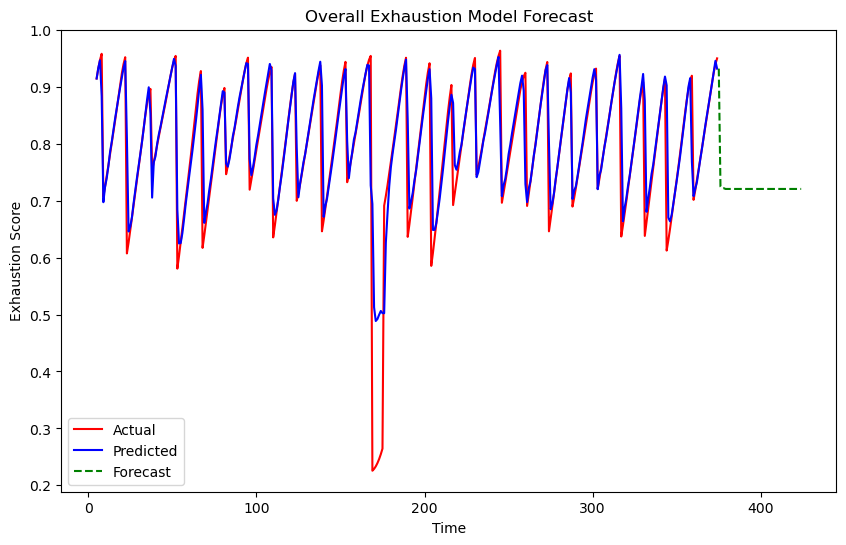

INFO: Created LSTM sequences: (370, 5, 9), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

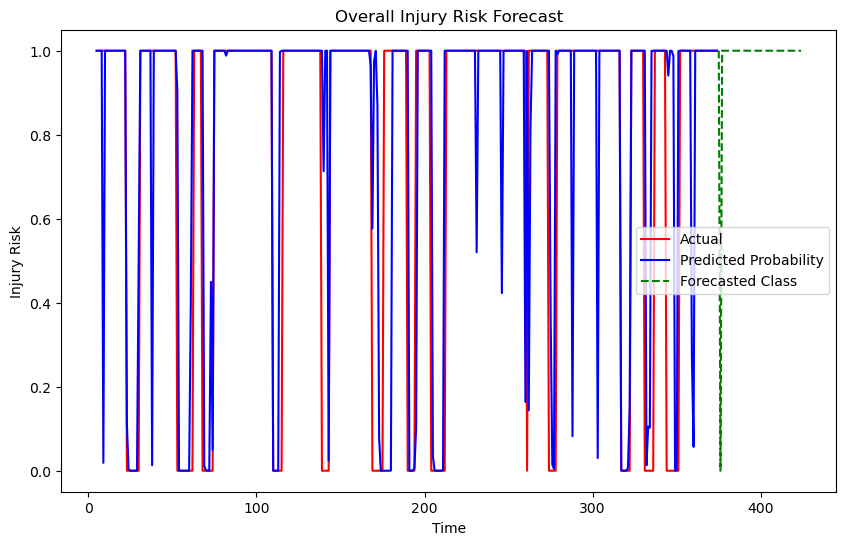

INFO: Created LSTM sequences: (370, 5, 9), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

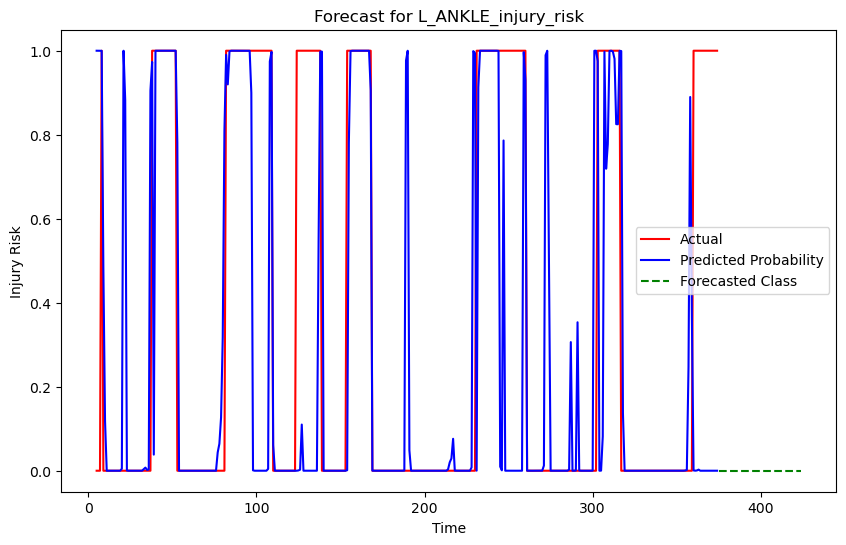

INFO: Created LSTM sequences: (370, 5, 9), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

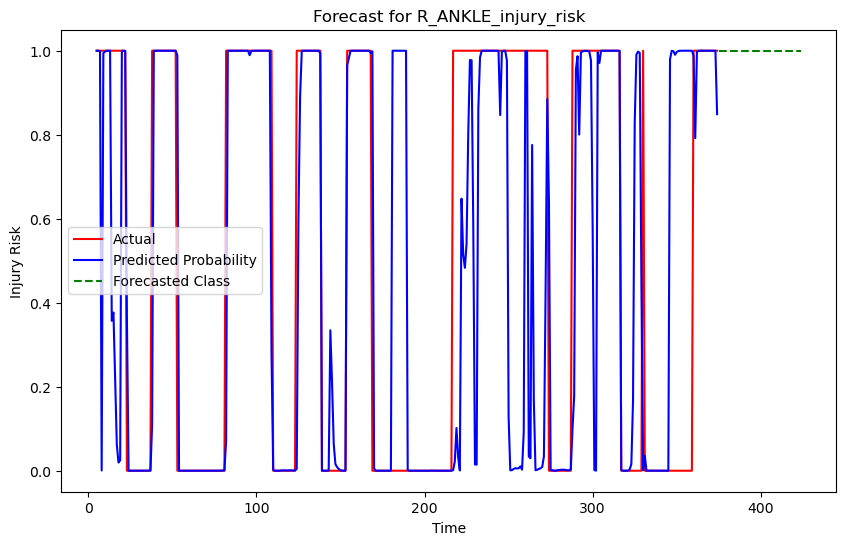

INFO: Created LSTM sequences: (370, 5, 9), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

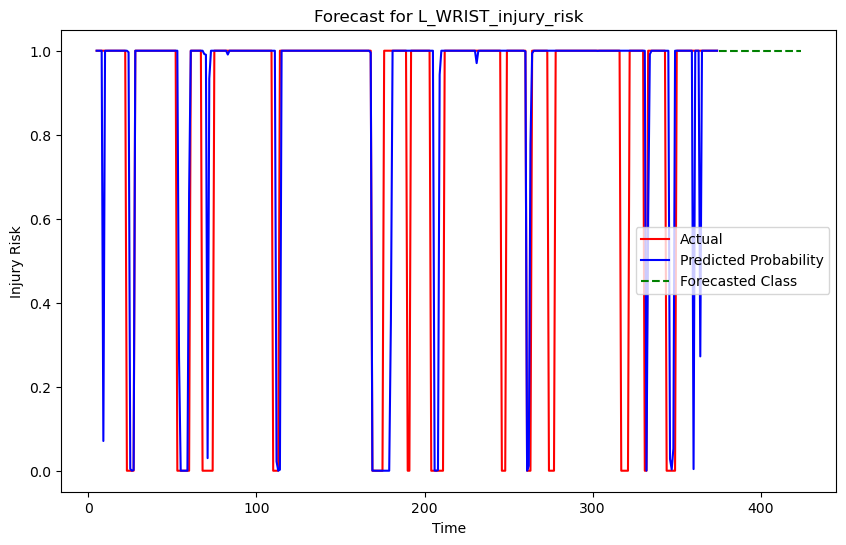

INFO: Created LSTM sequences: (370, 5, 10), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

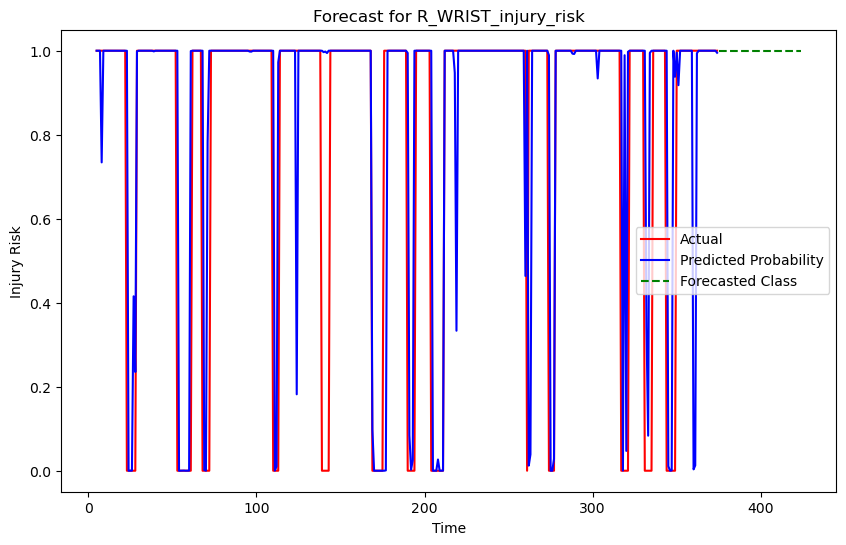

INFO: Created LSTM sequences: (370, 5, 9), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

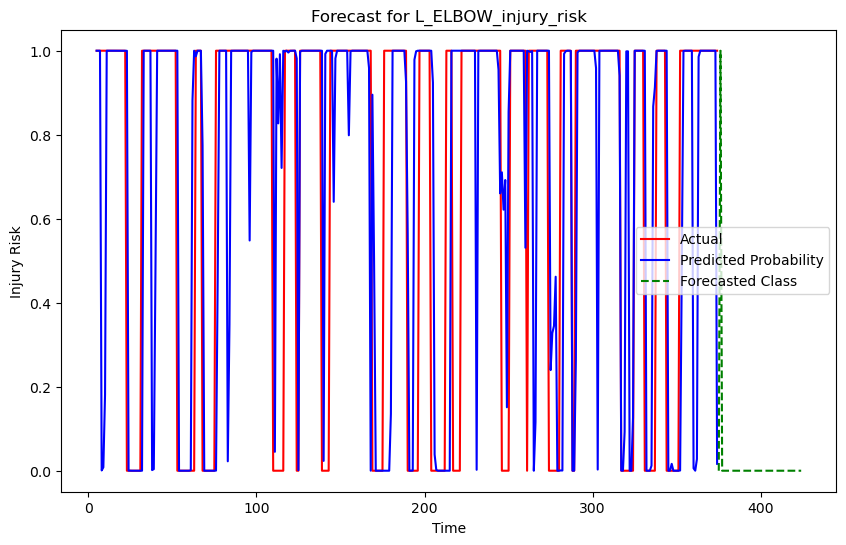

INFO: Created LSTM sequences: (370, 5, 9), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

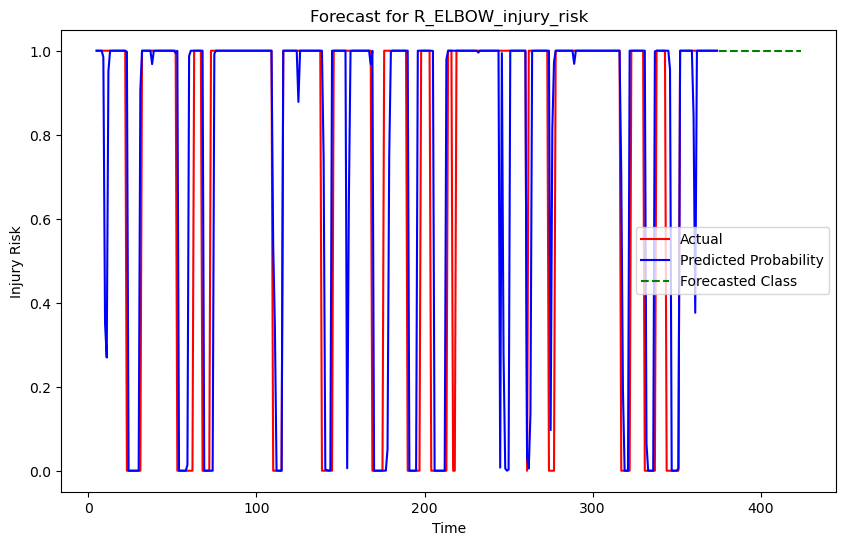

INFO: Created LSTM sequences: (370, 5, 9), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

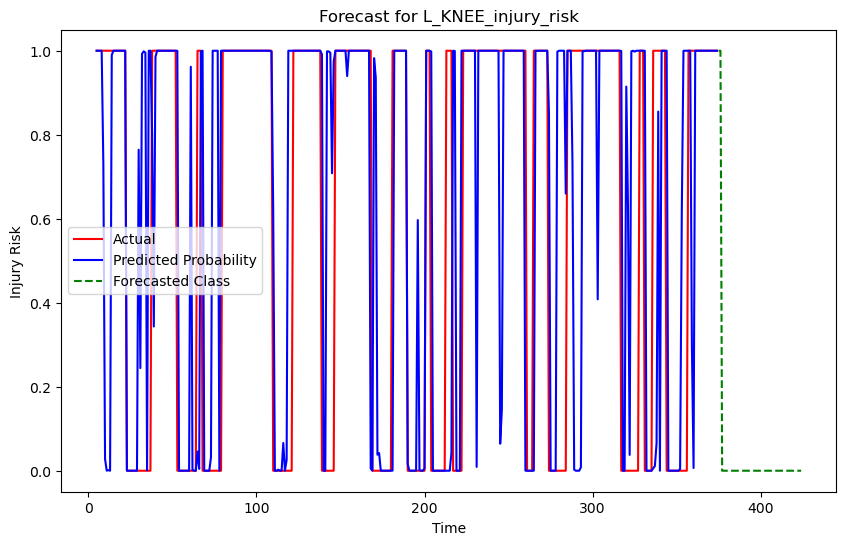

INFO: Created LSTM sequences: (370, 5, 8), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

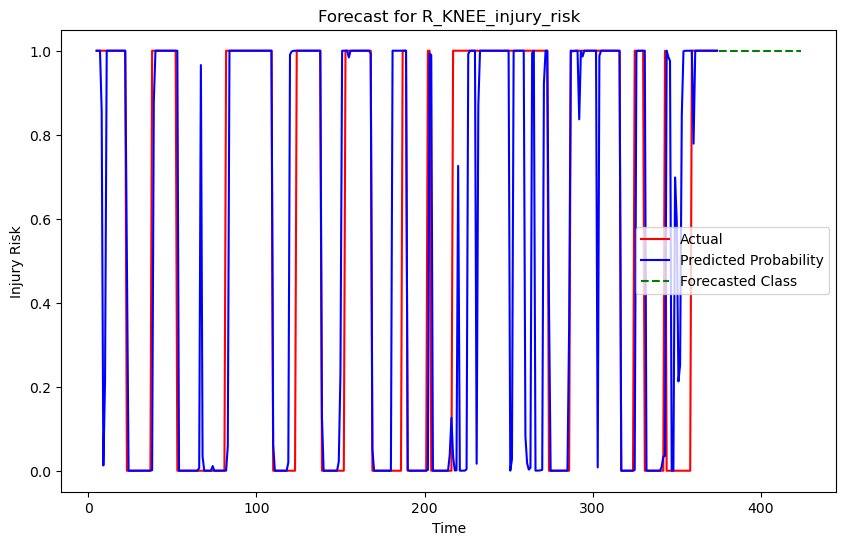

INFO: Created LSTM sequences: (370, 5, 9), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

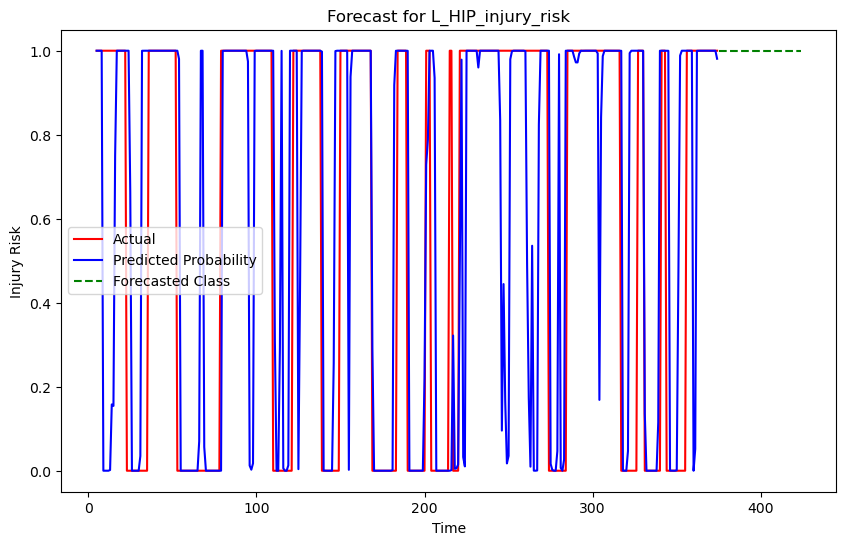

INFO: Created LSTM sequences: (370, 5, 9), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

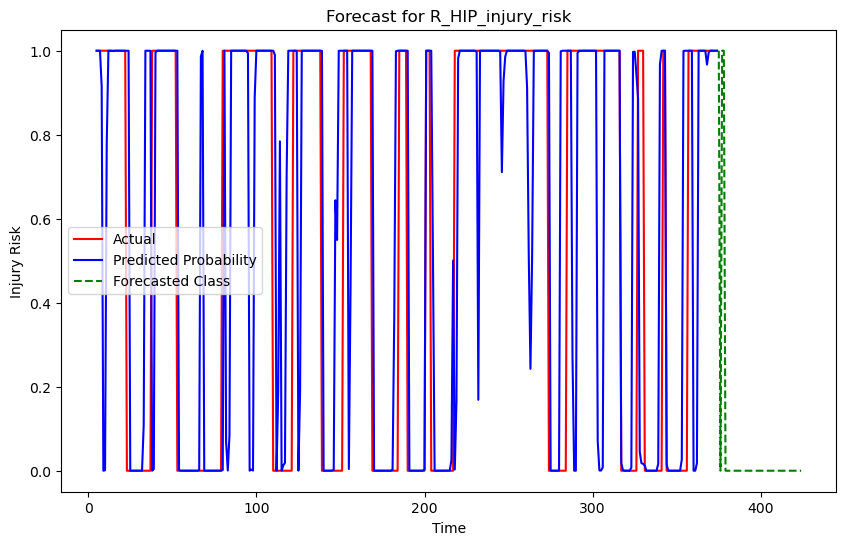

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 9), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 9), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 9), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 10), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 9), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 9), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 9), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 8), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 9), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 9), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Saved model summary dataframe to ..\..\data\Deep_Learning_Final\model_summary.csv
INFO: Summary features for aggregated datasets: ['joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry', 'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM', 'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM', 'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk', 'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg',

=== Model Summaries (Base Data) ===
None
Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: nan - val_loss: nan
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: nan - val_loss: nan
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: nan - val_loss: nan
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: nan - val_loss: nan
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: nan - val_loss: nan
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: nan - val_loss: nan


c:\Users\ghadf\anaconda3\envs\data_science_ft_bio_predictions\lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\ghadf\anaconda3\envs\data_science_ft_bio_predictions\lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\ghadf\anaconda3\envs\data_science_ft_bio_predictions\lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (95, 5, 61), (95,)
INFO: Created LSTM sequences: (20, 5, 61), (20,)
INFO: Training overall injury risk model...


Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0

INFO: Created LSTM sequences: (20, 5, 61), (20,)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

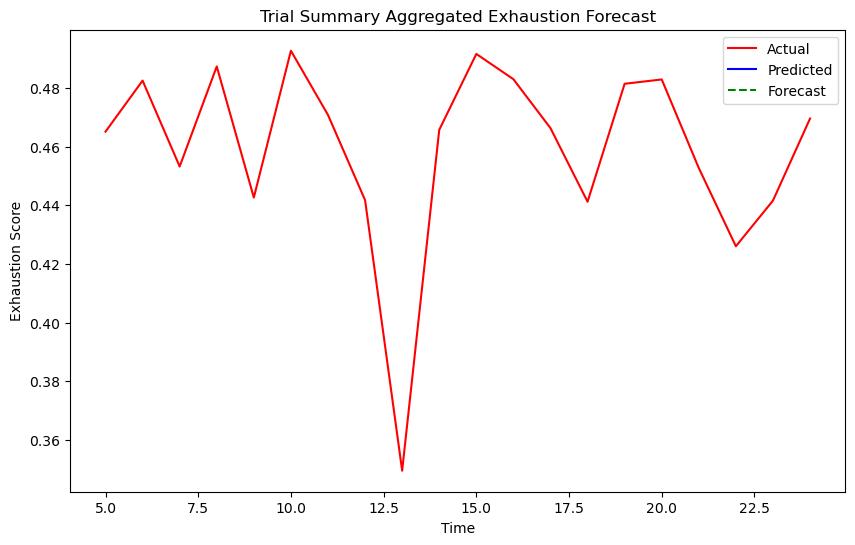

INFO: Created LSTM sequences: (20, 5, 61), (20,)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

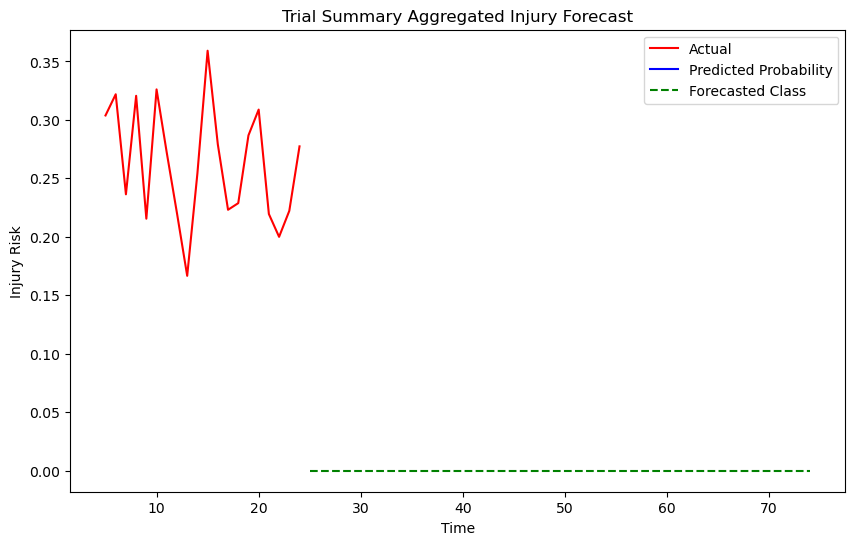

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


ValueError: Input contains NaN.

In [ ]:
import numpy as np
import pandas as pd
import json
import sys
import logging
from pathlib import Path

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, r2_score, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns


# ==================== UTILS ====================
def load_top_features(target, feature_dir="feature_lists"):
    """
    Loads the saved feature list for a specific target variable.
    
    Parameters:
      - target (str): Target variable name.
      - feature_dir (str): Directory containing feature lists.
    
    Returns:
      - List of feature names.
    """
    filename = Path(feature_dir) / f"{target}_model_feature_list.pkl"
    
    try:
        features = pd.read_pickle(filename)
        logging.info(f"Loaded {len(features)} features for {target}")
        
        # Verify features exist in data (assumes 'data' is already loaded in the global scope)
        missing = [f for f in features if f not in data.columns]
        if missing:
            logging.error(f"Missing features from {target} list: {missing}")
            sys.exit(1)
            
        return features
    
    except FileNotFoundError:
        logging.error(f"No feature list found for {target} at {filename}")
        sys.exit(1)
        
def temporal_train_test_split(data, test_size=0.2):
    """Time-based split maintaining temporal order"""
    split_idx = int(len(data) * (1 - test_size))
    train_data = data.iloc[:split_idx]
    test_data = data.iloc[split_idx:]
    logging.info(f"Performed temporal train-test split with test size = {test_size}")
    logging.info(f"Training data shape: {train_data.shape}, Testing data shape: {test_data.shape}")
    return train_data, test_data

def scale_features(X_train, X_test):
    """
    Scales features using StandardScaler.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    logging.info("Features have been scaled using StandardScaler.")
    return X_train_scaled, X_test_scaled, scaler

def create_sequences(X, y, timesteps):
    """
    Creates sequences of data for LSTM input.
    """
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i])
        y_seq.append(y[i])
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    logging.info(f"Created LSTM sequences: {X_seq.shape}, {y_seq.shape}")
    return X_seq, y_seq
# ==================== TRAINING FUNCTIONS ====================

def train_exhaustion_model(train_data, test_data, features, timesteps, 
                           epochs=50, batch_size=32, early_stop_patience=5,
                           num_lstm_layers=1, lstm_units=64, dropout_rate=0.2,
                           dense_units=1, dense_activation=None):
    """
    Trains the overall exhaustion model (regression) with a separate target scaler.

    Parameters:
      - train_data (DataFrame): Training set.
      - test_data (DataFrame): Testing set.
      - features (list): List of feature column names for exhaustion.
      - timesteps (int): Number of past observations to include in each sequence.
      - epochs (int): Number of training epochs.
      - batch_size (int): Batch size for training.
      - early_stop_patience (int): Patience for EarlyStopping callback.
      - num_lstm_layers (int): Number of LSTM layers in the model.
      - lstm_units (int): Number of units in each LSTM layer.
      - dropout_rate (float): Dropout rate applied after each LSTM layer.
      - dense_units (int): Number of units in the final Dense layer.
      - dense_activation (str or None): Activation function for the Dense layer.
      
    Returns:
      - model_exhaustion: Trained Keras model.
      - scaler_exhaustion: Fitted scaler for the features.
      - target_scaler: Fitted scaler for the target values.
      - X_lstm_exhaustion_val, y_lstm_exhaustion_val: Validation sequences (targets are scaled).
    """
    # Extract features and target from training and testing data
    X_train = train_data[features].values
    y_train = train_data['by_trial_exhaustion_score'].values
    X_test = test_data[features].values
    y_test = test_data['by_trial_exhaustion_score'].values

    # Scale features using the existing helper function
    X_train_scaled, X_test_scaled, scaler_exhaustion = scale_features(X_train, X_test)
    
    # ---- New: Scale the target (exhaustion scores) separately ----
    from sklearn.preprocessing import StandardScaler
    target_scaler = StandardScaler()
    # Reshape y to 2D arrays for StandardScaler
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))
    # ------------------------------------------------------------------

    # Create sequences for LSTM input using the scaled features and scaled target values
    X_lstm, y_lstm = create_sequences(X_train_scaled, y_train_scaled, timesteps)
    X_lstm_val, y_lstm_val = create_sequences(X_test_scaled, y_test_scaled, timesteps)

    # ---- Model Construction using an explicit Input layer and architecture hyperparameters ----
    from tensorflow.keras import Input
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dropout, Dense

    model_exhaustion = Sequential()
    # Define the input shape
    model_exhaustion.add(Input(shape=(X_lstm.shape[1], X_lstm.shape[2])))
    # Add LSTM layers with dropout (all but last LSTM layer return sequences)
    for i in range(num_lstm_layers):
        return_seq = True if i < num_lstm_layers - 1 else False
        model_exhaustion.add(LSTM(lstm_units, return_sequences=return_seq))
        model_exhaustion.add(Dropout(dropout_rate))
    # Final Dense layer for output (for regression, no activation by default)
    model_exhaustion.add(Dense(dense_units, activation=dense_activation))
    # ----------------------------------------------------------------------------------------------

    model_exhaustion.compile(optimizer='adam', loss='mse')

    from tensorflow.keras.callbacks import EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=early_stop_patience)

    import logging
    logging.info("Training overall exhaustion model...")
    model_exhaustion.fit(
        X_lstm, y_lstm,
        epochs=epochs, 
        batch_size=batch_size,
        validation_data=(X_lstm_val, y_lstm_val),
        callbacks=[early_stop]
    )

    # Return the model, the scaler for features, the separate target scaler, and validation sequences
    return model_exhaustion, scaler_exhaustion, target_scaler, X_lstm_val, y_lstm_val




def train_injury_model(train_data, test_data, features, timesteps,
                       epochs=50, batch_size=32,
                       num_lstm_layers=1, lstm_units=64, dropout_rate=0.2,
                       dense_units=1, dense_activation='sigmoid'):
    """
    Trains the overall injury risk model.

    Parameters:
      - train_data (DataFrame): Training set.
      - test_data (DataFrame): Testing set.
      - features (list): List of feature column names for injury risk.
      - timesteps (int): Number of past observations to include in each sequence.
      - epochs (int): Number of training epochs.
      - batch_size (int): Batch size for training.
      - num_lstm_layers (int): Number of LSTM layers in the model.
      - lstm_units (int): Number of units in each LSTM layer.
      - dropout_rate (float): Dropout rate applied after each LSTM layer.
      - dense_units (int): Number of units in the final Dense layer.
      - dense_activation (str): Activation function for the Dense layer (default 'sigmoid' for classification).
      
    Returns:
      - model_injury: Trained Keras model.
      - scaler_injury: Fitted scaler for the features.
      - X_lstm_injury_val, y_lstm_injury_val: Validation sequences.
    """
    X_train = train_data[features].values
    y_train = train_data['injury_risk'].values
    X_test = test_data[features].values
    y_test = test_data['injury_risk'].values

    # Scale features
    X_train_scaled, X_test_scaled, scaler_injury = scale_features(X_train, X_test)
    # Create sequences for LSTM input
    X_lstm, y_lstm = create_sequences(X_train_scaled, y_train, timesteps)
    X_lstm_val, y_lstm_val = create_sequences(X_test_scaled, y_test, timesteps)

    # ---- Updated Model Construction using an explicit Input layer and architecture hyperparameters ----
    from tensorflow.keras import Input
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dropout, Dense

    model_injury = Sequential()
    model_injury.add(Input(shape=(X_lstm.shape[1], X_lstm.shape[2])))
    for i in range(num_lstm_layers):
        return_seq = True if i < num_lstm_layers - 1 else False
        model_injury.add(LSTM(lstm_units, return_sequences=return_seq))
        model_injury.add(Dropout(dropout_rate))
    model_injury.add(Dense(dense_units, activation=dense_activation))
    # ----------------------------------------------------------------------------------------------

    model_injury.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    import logging
    logging.info("Training overall injury risk model...")
    model_injury.fit(
        X_lstm, y_lstm,
        epochs=epochs, 
        batch_size=batch_size,
        validation_data=(X_lstm_val, y_lstm_val)
    )

    return model_injury, scaler_injury, X_lstm_val, y_lstm_val
# ==================== JOINT-SPECIFIC TRAINING FUNCTION ====================



def train_joint_models(train_data, test_data, joints, timesteps, feature_dir,
                       epochs=50, batch_size=32,
                       num_lstm_layers=1, lstm_units=64, dropout_rate=0.2,
                       dense_units=1, dense_activation='sigmoid'):
    """
    Trains injury risk models for multiple joints.

    Parameters:
      - train_data (DataFrame): Training set.
      - test_data (DataFrame): Testing set.
      - joints (list): List of joint names.
      - timesteps (int): Number of past observations to include in each sequence.
      - feature_dir (str): Directory containing feature lists.
      - epochs (int): Number of training epochs.
      - batch_size (int): Batch size for training.
      - num_lstm_layers (int): Number of LSTM layers in the model.
      - lstm_units (int): Number of units in each LSTM layer.
      - dropout_rate (float): Dropout rate applied after each LSTM layer.
      - dense_units (int): Number of units in the final Dense layer.
      - dense_activation (str): Activation function for the Dense layer.
      
    Returns:
      - joint_models (dict): Dictionary with joint model info.
    """
    import logging
    from tensorflow.keras import Input
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dropout, Dense
    joint_models = {}

    for joint in joints:
        for side in ['L', 'R']:
            target_joint = f"{side}_{joint}_injury_risk"
            logging.info(f"Training model for {target_joint}...")

            joint_features = load_top_features(target_joint, feature_dir=feature_dir)

            X_train_joint = train_data[joint_features].values
            y_train_joint = train_data[target_joint].values
            X_test_joint = test_data[joint_features].values
            y_test_joint = test_data[target_joint].values

            # Scale features for the joint-specific model
            X_train_scaled, X_test_scaled, scaler_joint = scale_features(X_train_joint, X_test_joint)
            # Create sequences for LSTM input
            X_lstm, y_lstm = create_sequences(X_train_scaled, y_train_joint, timesteps)
            X_lstm_val, y_lstm_val = create_sequences(X_test_scaled, y_test_joint, timesteps)

            # ---- Updated Model Construction using an explicit Input layer and architecture hyperparameters ----
            model_joint = Sequential()
            model_joint.add(Input(shape=(X_lstm.shape[1], X_lstm.shape[2])))
            for i in range(num_lstm_layers):
                return_seq = True if i < num_lstm_layers - 1 else False
                model_joint.add(LSTM(lstm_units, return_sequences=return_seq))
                model_joint.add(Dropout(dropout_rate))
            model_joint.add(Dense(dense_units, activation=dense_activation))
            # ----------------------------------------------------------------------------------------------

            model_joint.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

            model_joint.fit(
                X_lstm, y_lstm,
                epochs=epochs, 
                batch_size=batch_size,
                validation_data=(X_lstm_val, y_lstm_val)
            )

            joint_models[target_joint] = {
                'model': model_joint,
                'features': joint_features,
                'scaler': scaler_joint
            }

    import json
    with open("loaded_features.json", "w") as f:
        json.dump({target: info['features'] for target, info in joint_models.items()}, f, indent=4)
    logging.info("Saved loaded features list for each joint model to 'loaded_features.json'.")

    return joint_models




# ==================== FORECASTING FUNCTION ====================

def forecast_and_plot_exhaustion(model, test_data, forecast_features, scaler_exhaustion, target_scaler, timesteps, future_steps=0, title="Exhaustion Forecast"):
    """
    Generates predictions for the exhaustion target using multi-feature input.
    
    This function extracts the same features used during training (e.g. a 10-dimensional input),
    scales them with the features scaler (scaler_exhaustion), builds forecasting sequences, makes predictions,
    and finally inverse-transforms the predictions using the target scaler.
    
    Parameters:
      - model: Trained exhaustion Keras model.
      - test_data (DataFrame): The test DataFrame containing all features.
      - forecast_features (list): List of feature names used for forecasting (e.g. features_exhaustion).
      - scaler_exhaustion: Fitted StandardScaler used to scale the features.
      - target_scaler: Fitted StandardScaler used to scale the target values.
      - timesteps (int): Number of past observations to include in each sequence.
      - future_steps (int): Number of future time steps to forecast.
                          (Note: Future forecasting is approximate since it assumes constant features.)
      - title (str): Plot title.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Extract multi-dimensional input from test data
    X_forecast = test_data[forecast_features].values  # shape (n, num_features)
    
    # Scale the features using the features scaler
    X_forecast_scaled = scaler_exhaustion.transform(X_forecast)
    
    # Create sequences for forecasting using a dummy y array (since only X is needed)
    X_seq, _ = create_sequences(X_forecast_scaled, np.zeros(len(X_forecast_scaled)), timesteps)
    
    # Make predictions on the scaled sequences
    predictions_scaled = model.predict(X_seq)
    # Inverse-transform predictions using the target scaler
    predictions = target_scaler.inverse_transform(predictions_scaled)
    
    forecast_predictions_inv = None
    if future_steps > 0:
        # For additional future steps, we assume the features remain constant.
        # WARNING: This is an approximation.
        current_sequence = X_seq[-1].copy()  # shape: (timesteps, num_features)
        forecast_predictions = []
        for _ in range(future_steps):
            next_pred = model.predict(current_sequence.reshape(1, timesteps, current_sequence.shape[1]))
            forecast_predictions.append(next_pred[0, 0])
            # Update sequence: drop the first row and append the last row (assumed constant)
            new_row = current_sequence[-1, :].copy()
            current_sequence = np.vstack([current_sequence[1:], new_row])
        forecast_predictions = np.array(forecast_predictions).reshape(-1, 1)
        forecast_predictions_inv = target_scaler.inverse_transform(forecast_predictions)
    
    # Plot actual exhaustion scores versus predictions
    plt.figure(figsize=(10, 6))
    actual = test_data['by_trial_exhaustion_score'].values
    plt.plot(range(timesteps, len(actual)), actual[timesteps:], color='red', label='Actual')
    plt.plot(range(timesteps, len(actual)), predictions, color='blue', label='Predicted')
    if forecast_predictions_inv is not None:
        future_x = list(range(len(actual), len(actual) + future_steps))
        plt.plot(future_x, forecast_predictions_inv, color='green', linestyle='--', label='Forecast')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Exhaustion Score')
    plt.legend()
    plt.show()


def forecast_and_plot_injury(model, test_data, forecast_features, scaler_injury, timesteps, future_steps=0, title="Injury Risk Forecast"):
    """
    Generates predictions for the injury risk model using multi-feature input.
    
    This function extracts the injury features from the test data, scales them using scaler_injury,
    builds forecasting sequences, and makes predictions. Since this is a classification model,
    it outputs probability predictions. These probabilities (or rounded binary classes) are compared
    to the actual injury risk (assumed to be 0 or 1).
    
    Parameters:
      - model: Trained injury risk Keras model.
      - test_data (DataFrame): The test DataFrame containing all features.
      - forecast_features (list): List of feature names used for forecasting (e.g. features_injury).
      - scaler_injury: Fitted StandardScaler used to scale the injury features.
      - timesteps (int): Number of past observations to include in each sequence.
      - future_steps (int): Number of future time steps to forecast.
                          (For classification, future forecasting is less common.)
      - title (str): Plot title.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Extract multi-dimensional input for injury risk from test data
    X_forecast = test_data[forecast_features].values  # shape (n, num_features)
    
    # Scale the features using the injury features scaler
    X_forecast_scaled = scaler_injury.transform(X_forecast)
    
    # Create sequences for forecasting (dummy y used, since only X is needed)
    X_seq, _ = create_sequences(X_forecast_scaled, np.zeros(len(X_forecast_scaled)), timesteps)
    
    # Predict probabilities on the sequences
    predictions_prob = model.predict(X_seq)
    # Convert probabilities to binary predictions (threshold=0.5)
    predictions_class = (predictions_prob >= 0.5).astype(int)
    
    forecast_predictions = None
    if future_steps > 0:
        # For future steps, we assume features remain constant (approximation)
        current_sequence = X_seq[-1].copy()  # shape: (timesteps, num_features)
        forecast_predictions = []
        for _ in range(future_steps):
            next_pred = model.predict(current_sequence.reshape(1, timesteps, current_sequence.shape[1]))
            forecast_predictions.append((next_pred[0, 0] >= 0.5).astype(int))
            new_row = current_sequence[-1, :].copy()
            current_sequence = np.vstack([current_sequence[1:], new_row])
        forecast_predictions = np.array(forecast_predictions)
    
    # Plot the actual injury risk versus predicted probability (or binary prediction)
    plt.figure(figsize=(10, 6))
    actual = test_data['injury_risk'].values
    # For plotting, we align the sequences starting at index 'timesteps'
    plt.plot(range(timesteps, len(actual)), actual[timesteps:], color='red', label='Actual')
    plt.plot(range(timesteps, len(actual)), predictions_prob, color='blue', label='Predicted Probability')
    if forecast_predictions is not None:
        future_x = list(range(len(actual), len(actual) + future_steps))
        plt.plot(future_x, forecast_predictions, color='green', linestyle='--', label='Forecasted Class')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Injury Risk')
    plt.legend()
    plt.show()


def forecast_and_plot_joint(joint_models, test_data, timesteps, future_steps=0):
    """
    Generates forecasts for each joint model using their corresponding features and scalers.
    
    For each joint model in the joint_models dictionary (returned by train_joint_models),
    this function extracts the joint-specific features from test_data, scales them using the model's scaler,
    builds sequences, obtains predictions (probabilities), converts them to binary predictions,
    and then plots the actual joint injury risk versus predicted values.
    
    Parameters:
      - joint_models (dict): Dictionary where each key is a joint target name and each value is a dict 
                             containing 'model', 'features', and 'scaler'.
      - test_data (DataFrame): The test DataFrame containing all features.
      - timesteps (int): Number of past observations to include in each sequence.
      - future_steps (int): Number of future time steps to forecast (optional).
    """
    import numpy as np
    import matplotlib.pyplot as plt

    for target_joint, info in joint_models.items():
        model_joint = info['model']
        joint_features = info['features']
        scaler_joint = info['scaler']
        
        # Extract joint-specific features from test data
        X_forecast = test_data[joint_features].values  # shape (n, num_features)
        # Scale the features
        X_forecast_scaled = scaler_joint.transform(X_forecast)
        # Create sequences for forecasting (dummy y used)
        X_seq, _ = create_sequences(X_forecast_scaled, np.zeros(len(X_forecast_scaled)), timesteps)
        
        # Predict probabilities and convert to binary predictions
        predictions_prob = model_joint.predict(X_seq)
        predictions_class = (predictions_prob >= 0.5).astype(int)
        
        forecast_predictions = None
        if future_steps > 0:
            # Approximate forecasting by assuming constant features
            current_sequence = X_seq[-1].copy()  # shape: (timesteps, num_features)
            forecast_predictions = []
            for _ in range(future_steps):
                next_pred = model_joint.predict(current_sequence.reshape(1, timesteps, current_sequence.shape[1]))
                forecast_predictions.append((next_pred[0, 0] >= 0.5).astype(int))
                new_row = current_sequence[-1, :].copy()
                current_sequence = np.vstack([current_sequence[1:], new_row])
            forecast_predictions = np.array(forecast_predictions)
        
        # Plot for this joint model
        plt.figure(figsize=(10, 6))
        actual = test_data[target_joint].values
        plt.plot(range(timesteps, len(actual)), actual[timesteps:], color='red', label='Actual')
        plt.plot(range(timesteps, len(actual)), predictions_prob, color='blue', label='Predicted Probability')
        if forecast_predictions is not None:
            future_x = list(range(len(actual), len(actual) + future_steps))
            plt.plot(future_x, forecast_predictions, color='green', linestyle='--', label='Forecasted Class')
        plt.title(f"Forecast for {target_joint}")
        plt.xlabel('Time')
        plt.ylabel('Injury Risk')
        plt.legend()
        plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

def summarize_exhaustion_model(model, X_val, y_val, target_scaler, debug=False):
    """
    Generates evaluation metrics for the exhaustion (regression) model.
    
    Added debug statements to check the predictions before and after inverse transformation.
    These prints help to verify that the predicted outputs and the true target values are finite.
    
    Parameters:
      - model: Trained exhaustion Keras model.
      - X_val: Validation features (sequences) used for prediction.
      - y_val: Validation target values (scaled).
      - target_scaler: Fitted StandardScaler used to inverse transform the targets.
      - debug (bool): If True, prints debug output.
      
    Returns:
      - A dictionary with evaluation metrics: MSE, MAE, and R2 Score.
    """
    preds_scaled = model.predict(X_val)
    if debug:
        print("Step 4: After prediction (scaled predictions)")
        print("preds_scaled stats:", np.nanmin(preds_scaled), np.nanmax(preds_scaled), np.isnan(preds_scaled).sum())
    
    preds = target_scaler.inverse_transform(preds_scaled)
    y_true = target_scaler.inverse_transform(y_val)
    
    if debug:
        print("Step 4: After inverse transformation")
        print("After inverse transform, preds stats:", np.nanmin(preds), np.nanmax(preds), np.isnan(preds).sum())
        print("After inverse transform, y_true stats:", np.nanmin(y_true), np.nanmax(y_true), np.isnan(y_true).sum())
    
    mse = mean_squared_error(y_true, preds)
    mae = mean_absolute_error(y_true, preds)
    r2 = r2_score(y_true, preds)
    
    return {"MSE": mse, "MAE": mae, "R2 Score": r2}


def summarize_classification_model(model, X_val, y_val):
    """
    Generates evaluation metrics for a classification model.
    """
    preds_prob = model.predict(X_val)
    preds_class = (preds_prob >= 0.5).astype(int)
    
    accuracy = accuracy_score(y_val, preds_class)
    precision = precision_score(y_val, preds_class, zero_division=0)
    recall = recall_score(y_val, preds_class, zero_division=0)
    f1 = f1_score(y_val, preds_class, zero_division=0)
    
    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}

def summarize_joint_models(joint_models, test_data, timesteps):
    """
    Computes evaluation metrics for each joint model.
    """
    summaries = {}
    for target_joint, info in joint_models.items():
        model_joint = info['model']
        joint_features = info['features']
        scaler_joint = info['scaler']
        
        X_joint = test_data[joint_features].values
        y_joint = test_data[target_joint].values
        
        X_joint_scaled = scaler_joint.transform(X_joint)
        X_seq, y_seq = create_sequences(X_joint_scaled, y_joint, timesteps)
        
        metrics = summarize_classification_model(model_joint, X_seq, y_seq)
        summaries[target_joint] = metrics
    return summaries

def summarize_all_models(model_exhaustion, X_val_exh, y_val_exh, target_scaler,
                         model_injury, X_val_injury, y_val_injury,
                         joint_models, test_data, timesteps, output_dir):
    """
    Combines summaries from the exhaustion, injury, and joint models into a table.
    """
    summary_data = []
    exh_metrics = summarize_exhaustion_model(model_exhaustion, X_val_exh, y_val_exh, target_scaler)
    summary_data.append({
        "Model": "Exhaustion Model",
        "Type": "Regression",
        "MSE": exh_metrics.get("MSE"),
        "MAE": exh_metrics.get("MAE"),
        "R2 Score": exh_metrics.get("R2 Score"),
        "Accuracy": None,
        "Precision": None,
        "Recall": None,
        "F1 Score": None
    })
    
    injury_metrics = summarize_classification_model(model_injury, X_val_injury, y_val_injury)
    summary_data.append({
        "Model": "Injury Model",
        "Type": "Classification",
        "MSE": None,
        "MAE": None,
        "R2 Score": None,
        "Accuracy": injury_metrics.get("Accuracy"),
        "Precision": injury_metrics.get("Precision"),
        "Recall": injury_metrics.get("Recall"),
        "F1 Score": injury_metrics.get("F1 Score")
    })
    
    joint_summaries = summarize_joint_models(joint_models, test_data, timesteps)
    for target_joint, metrics in joint_summaries.items():
        summary_data.append({
            "Model": target_joint,
            "Type": "Classification",
            "MSE": None,
            "MAE": None,
            "R2 Score": None,
            "Accuracy": metrics.get("Accuracy"),
            "Precision": metrics.get("Precision"),
            "Recall": metrics.get("Recall"),
            "F1 Score": metrics.get("F1 Score")
        })
    
    summary_df = pd.DataFrame(summary_data)
    output_file = Path(output_dir) / "model_summary.csv"
    summary_df.to_csv(output_file, index=False)
    logging.info(f"Saved model summary dataframe to {output_file}")





if __name__ == "__main__":
    import logging
    logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

    # ======================
    # 1. Data Loading & Preparation
    # ======================
    csv_path = "../../data/processed/final_granular_dataset.csv"
    json_path = "../../data/basketball/freethrow/participant_information.json"
    feature_dir = "../../data/Deep_Learning_Final"
    # output_dir is used both for saving feature lists and for summaries.
    output_dir = "../../data/Deep_Learning_Final"
    
    # Load raw data and run initial feature engineering on the base data.
    data = load_data(csv_path, json_path, debug=True)
    data = prepare_joint_features(data, debug=True)
    data = feature_engineering(data, debug=True)
    data = data.copy()  # Defragment DataFrame
    print("Base data columns:", data.columns.tolist())
    
    # ======================
    # 2. Create Aggregated (Summarized) Datasets
    # ======================
    # Define the columns used for aggregation and the lag columns.
    default_agg_columns = [
        # Primary joint energies (key performance indicators)
        'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy',
        # Critical power metrics 
        'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 
        'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
        'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
        # Key asymmetry metrics (injury prevention indicators)
        'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
        # Critical joint angles (form analysis)
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 
        'L_KNEE_angle', 'R_KNEE_angle',
        # Essential ROM metrics (technique consistency)
        'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
        'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
        # Fatigue and injury risk indicators
        'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
        'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'simulated_HR',
        # Player physical attributes
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    
    default_lag_columns = [
        # Energy transfer metrics (fatigue indicators)
        'joint_energy', 'joint_power',
        'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        # Primary asymmetry metrics (technique degradation)
        'elbow_asymmetry', 'wrist_asymmetry',
        # Critical angles for shooting form
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle',
        # Fatigue indicators
        'exhaustion_rate', 'by_trial_exhaustion_score',
        'simulated_HR'
    ]
    rolling_window = 3
    
    # Create two aggregated datasets:
    # a. Trial summary data: aggregated by trial_id.
    trial_summary_data = summarize_data(
        data,
        groupby_cols=['trial_id'],
        lag_columns=default_lag_columns,
        rolling_window=rolling_window,
        agg_columns=default_agg_columns,
        debug=True
    )
    # b. Shot phase summary data: aggregated by trial_id and shooting_phases.
    shot_phase_summary_data = summarize_data(
        data,
        groupby_cols=['trial_id', 'shooting_phases'],
        lag_columns=default_lag_columns,
        rolling_window=rolling_window,
        agg_columns=default_agg_columns,
        phase_list=["arm_cock", "arm_release", "leg_cock", "wrist_release"],
        debug=True
    )
    print("Shot Phase Summary Sample:")
    print(shot_phase_summary_data.head())
    print("Trial Summary Sample:")
    print(trial_summary_data.head())
    
    # ======================
    # 3. Filter Base Data for Modeling
    # ======================
    # Filter the base data to include only rows where shooting_motion == 1.
    data = data[data['shooting_motion'] == 1]
    
    # ======================
    # 4. Load Selected Features for Base Models (from earlier feature importance)
    # ======================
    features_exhaustion = load_top_features('by_trial_exhaustion_score', feature_dir=feature_dir)
    features_injury = load_top_features('injury_risk', feature_dir=feature_dir)
    
    # ======================
    # 5. Split Base Data for Training Models
    # ======================
    train_data, test_data = temporal_train_test_split(data, test_size=0.2)
    timesteps = 5
    
    # Hyperparameters and architecture definitions (unchanged)
    hyperparams = {
        "epochs": 500,
        "batch_size": 32,
        "early_stop_patience": 5
    }
    arch_exhaustion = {
        "num_lstm_layers": 1,
        "lstm_units": 64,
        "dropout_rate": 0.2,
        "dense_units": 1,
        "dense_activation": None
    }
    arch_injury = {
        "num_lstm_layers": 1,
        "lstm_units": 64,
        "dropout_rate": 0.2,
        "dense_units": 1,
        "dense_activation": "sigmoid"
    }
    
    # ======================
    # 6. Train Models on Base Data
    # ======================
    model_exhaustion, scaler_exhaustion, target_scaler, X_val_exh, y_val_exh = train_exhaustion_model(
        train_data, test_data, features_exhaustion, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        early_stop_patience=hyperparams["early_stop_patience"],
        num_lstm_layers=arch_exhaustion["num_lstm_layers"],
        lstm_units=arch_exhaustion["lstm_units"],
        dropout_rate=arch_exhaustion["dropout_rate"],
        dense_units=arch_exhaustion["dense_units"],
        dense_activation=arch_exhaustion["dense_activation"]
    )
    model_injury, scaler_injury, X_val_injury, y_val_injury = train_injury_model(
        train_data, test_data, features_injury, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        num_lstm_layers=arch_injury["num_lstm_layers"],
        lstm_units=arch_injury["lstm_units"],
        dropout_rate=arch_injury["dropout_rate"],
        dense_units=arch_injury["dense_units"],
        dense_activation=arch_injury["dense_activation"]
    )
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    joint_models = train_joint_models(
        train_data, test_data, joints, timesteps, feature_dir,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        num_lstm_layers=arch_injury["num_lstm_layers"],
        lstm_units=arch_injury["lstm_units"],
        dropout_rate=arch_injury["dropout_rate"],
        dense_units=arch_injury["dense_units"],
        dense_activation=arch_injury["dense_activation"]
    )
    
    # ======================
    # 7. Forecasting for Base Models
    # ======================
    forecast_and_plot_exhaustion(
        model=model_exhaustion,
        test_data=test_data,
        forecast_features=features_exhaustion,
        scaler_exhaustion=scaler_exhaustion,
        target_scaler=target_scaler,
        timesteps=timesteps,
        future_steps=50,
        title="Overall Exhaustion Model Forecast"
    )
    forecast_and_plot_injury(
        model=model_injury,
        test_data=test_data,
        forecast_features=features_injury,
        scaler_injury=scaler_injury,
        timesteps=timesteps,
        future_steps=50,
        title="Overall Injury Risk Forecast"
    )
    forecast_and_plot_joint(
        joint_models=joint_models,
        test_data=test_data,
        timesteps=timesteps,
        future_steps=50
    )
    
    # ======================
    # 8. Summarize Base Model Testing Results
    # ======================
    summary_df = summarize_all_models(
        model_exhaustion, X_val_exh, y_val_exh, target_scaler,
        model_injury, X_val_injury, y_val_injury,
        joint_models, test_data, timesteps, output_dir
    )
    print("=== Model Summaries (Base Data) ===")
    print(summary_df)
    
    # ======================
    # 9. New: Train, Forecast, and Summarize Aggregated Models
    # ======================
    # Define a summary features list that consists of the aggregated columns
    # plus the lagged versions for the lag columns.
    summary_features = default_agg_columns + [f"{col}_lag1" for col in default_lag_columns]
    logging.info(f"Summary features for aggregated datasets: {summary_features}")
    
    # The aggregated datasets contain only the overall targets.
    summary_targets = ['by_trial_exhaustion_score', 'injury_risk']
    
    # --- 9a. Process Trial Summary Data ---
    # Split the trial summary aggregated data into train and test sets.
    trial_train_data, trial_test_data = temporal_train_test_split(trial_summary_data, test_size=0.2)
    
    # Train aggregated models on the trial summary dataset.
    model_exhaustion_trial, scaler_exhaustion_trial, target_scaler_trial, X_val_exh_trial, y_val_exh_trial = train_exhaustion_model(
        trial_train_data, trial_test_data, summary_features, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        early_stop_patience=hyperparams["early_stop_patience"],
        num_lstm_layers=arch_exhaustion["num_lstm_layers"],
        lstm_units=arch_exhaustion["lstm_units"],
        dropout_rate=arch_exhaustion["dropout_rate"],
        dense_units=arch_exhaustion["dense_units"],
        dense_activation=arch_exhaustion["dense_activation"]
    )
    model_injury_trial, scaler_injury_trial, X_val_injury_trial, y_val_injury_trial = train_injury_model(
        trial_train_data, trial_test_data, summary_features, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        num_lstm_layers=arch_injury["num_lstm_layers"],
        lstm_units=arch_injury["lstm_units"],
        dropout_rate=arch_injury["dropout_rate"],
        dense_units=arch_injury["dense_units"],
        dense_activation=arch_injury["dense_activation"]
    )
    
    # Forecast for the trial summary aggregated exhaustion model.
    forecast_and_plot_exhaustion(
        model=model_exhaustion_trial,
        test_data=trial_test_data,
        forecast_features=summary_features,
        scaler_exhaustion=scaler_exhaustion_trial,
        target_scaler=target_scaler_trial,
        timesteps=timesteps,
        future_steps=50,
        title="Trial Summary Aggregated Exhaustion Forecast"
    )
    # Forecast for the trial summary aggregated injury risk model.
    forecast_and_plot_injury(
        model=model_injury_trial,
        test_data=trial_test_data,
        forecast_features=summary_features,
        scaler_injury=scaler_injury_trial,
        timesteps=timesteps,
        future_steps=50,
        title="Trial Summary Aggregated Injury Forecast"
    )
    
    # Summarize aggregated trial model testing results.
    trial_summary_df = summarize_all_models(
        model_exhaustion_trial, X_val_exh_trial, y_val_exh_trial, target_scaler_trial,
        model_injury_trial, X_val_injury_trial, y_val_injury_trial,
        joint_models, trial_test_data, timesteps, output_dir
    )
    print("=== Model Summaries (Trial Summary Aggregated Data) ===")
    print(trial_summary_df)
    
    # --- 9b. Process Shot Phase Summary Data ---
    # For the shot phase aggregated data, we use the same summary features and overall targets.
    shot_train_data, shot_test_data = temporal_train_test_split(shot_phase_summary_data, test_size=0.2)
    
    # Train aggregated models on the shot phase summary dataset.
    model_exhaustion_shot, scaler_exhaustion_shot, target_scaler_shot, X_val_exh_shot, y_val_exh_shot = train_exhaustion_model(
        shot_train_data, shot_test_data, summary_features, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        early_stop_patience=hyperparams["early_stop_patience"],
        num_lstm_layers=arch_exhaustion["num_lstm_layers"],
        lstm_units=arch_exhaustion["lstm_units"],
        dropout_rate=arch_exhaustion["dropout_rate"],
        dense_units=arch_exhaustion["dense_units"],
        dense_activation=arch_exhaustion["dense_activation"]
    )
    model_injury_shot, scaler_injury_shot, X_val_injury_shot, y_val_injury_shot = train_injury_model(
        shot_train_data, shot_test_data, summary_features, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        num_lstm_layers=arch_injury["num_lstm_layers"],
        lstm_units=arch_injury["lstm_units"],
        dropout_rate=arch_injury["dropout_rate"],
        dense_units=arch_injury["dense_units"],
        dense_activation=arch_injury["dense_activation"]
    )
    
    # Forecast for the shot phase aggregated exhaustion model.
    forecast_and_plot_exhaustion(
        model=model_exhaustion_shot,
        test_data=shot_test_data,
        forecast_features=summary_features,
        scaler_exhaustion=scaler_exhaustion_shot,
        target_scaler=target_scaler_shot,
        timesteps=timesteps,
        future_steps=50,
        title="Shot Phase Summary Aggregated Exhaustion Forecast"
    )
    # Forecast for the shot phase aggregated injury risk model.
    forecast_and_plot_injury(
        model=model_injury_shot,
        test_data=shot_test_data,
        forecast_features=summary_features,
        scaler_injury=scaler_injury_shot,
        timesteps=timesteps,
        future_steps=50,
        title="Shot Phase Summary Aggregated Injury Forecast"
    )
    
    # Summarize aggregated shot phase model testing results.
    shot_summary_df = summarize_all_models(
        model_exhaustion_shot, X_val_exh_shot, y_val_exh_shot, target_scaler_shot,
        model_injury_shot, X_val_injury_shot, y_val_injury_shot,
        joint_models, shot_test_data, timesteps, output_dir
    )
    print("=== Model Summaries (Shot Phase Summary Aggregated Data) ===")
    print(shot_summary_df)



    